# Multi-Headed Simplex attention experiments on `SimplePeriodicDataset` with overlapping source and target 

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.rcParams["pdf.use14corefonts"] = True

import sys
import os
sys.path.append(os.path.abspath('../../'))  #Couldn't figure out how to get src in my path so i fixed it like this

from src.Transformer.DecoderOnly import PointSimplexDecoderOnlyTransformer
from src.Transformer.DistanceMetrics import euclidean, cosine, manhattan, infinity_norm


import src.Datasets.SyntheticDataset as SD
from src.train import train_step_dec_only, val_step_dec_only
from src.utils import collate_fn, EarlyStopping

ES = EarlyStopping(patience=45, delta=1)

In [2]:
# configs
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# meta data to store images
FOLDER = "simplex_transformer"
KERNEL_NAME = "simplex"

# transformer configs
n_layers = 2                            # number of decoder blocks
emb_size = 64                           # size of transformer block embedding (d_model)
ffn_n_hidden = emb_size * 4             # point-wise feed forward net hidden dimensions
norm_first = True                       # LayerNorm order (keep consistent)
conv_out_dim = 32                            # Output dimension for convolutional part in Simplex block (example value)
kernel_size = 5                              # Kernel size for convolutional part in Simplex block (example value)

# Experiment parameters, these will be changed in the following experiments
n_heads=1                                    # Number of Heads
distance_metric = euclidean                  # Distance metric in custom simplex attention


# train configs
ps = [0.5, 0.9]                         # rho_quantile loss probs
lr = 0.0005                             # initial learning rate
lr_step_size = 10                       # every n steps decrease learning rate by gamma
lr_gamma = 0.95                         # learning rate decrease rate
EPOCHS = 300                            # training epochs

In [3]:
DATASET_NAME = "simple_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 1                               # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=False, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=False, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

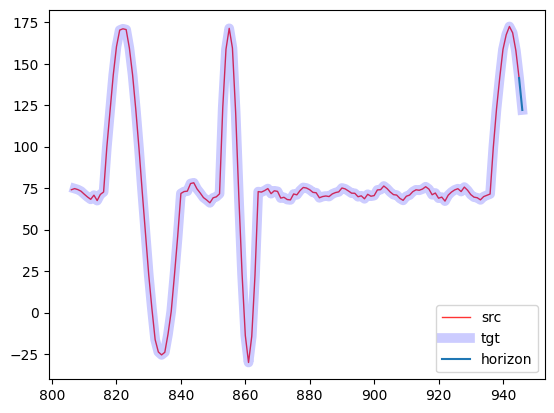

In [4]:
src_X, src_fX, tgt_X, tgt_fX = train_set[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

## Experiment 1: One-step and N-step prediction using *one head* and the *euclidean* distance function.

### Training setup

In [5]:
n_heads = 1                               # Number of heads used in multi headed simplex attention
distance_metric = euclidean                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [6]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2663.2660	val_loss=1500.5442	train_mape_loss=2.6795	val_mape_loss=3.6920	R_p=['0.2761', '0.2604']
epoch=1	train_loss=1507.3006	val_loss=1447.7305	train_mape_loss=3.3150	val_mape_loss=3.6944	R_p=['0.2839', '0.2562']
epoch=2	train_loss=1448.1370	val_loss=1199.7665	train_mape_loss=3.2861	val_mape_loss=3.6533	R_p=['0.3235', '0.2308']
epoch=3	train_loss=1297.3303	val_loss=947.3216	train_mape_loss=2.9888	val_mape_loss=2.6320	R_p=['0.2870', '0.2316']
epoch=4	train_loss=1127.7603	val_loss=876.2465	train_mape_loss=2.6491	val_mape_loss=2.5955	R_p=['0.2853', '0.2349']
epoch=5	train_loss=1027.6757	val_loss=899.5300	train_mape_loss=2.4253	val_mape_loss=2.4188	R_p=['0.3022', '0.2359']
epoch=6	train_loss=951.7864	val_loss=912.4815	train_mape_loss=2.2787	val_mape_loss=2.4926	R_p=['0.3103', '0.2385']
epoch=7	train_loss=905.1691	val_loss=857.2501	train_mape_loss=2.1667	val_mape_loss=2.5582	R_p=['0.2806', '0.2418']
epoch=8	train_loss=885.1344	val_loss=840.8625	train_mape_loss=2.1594	va

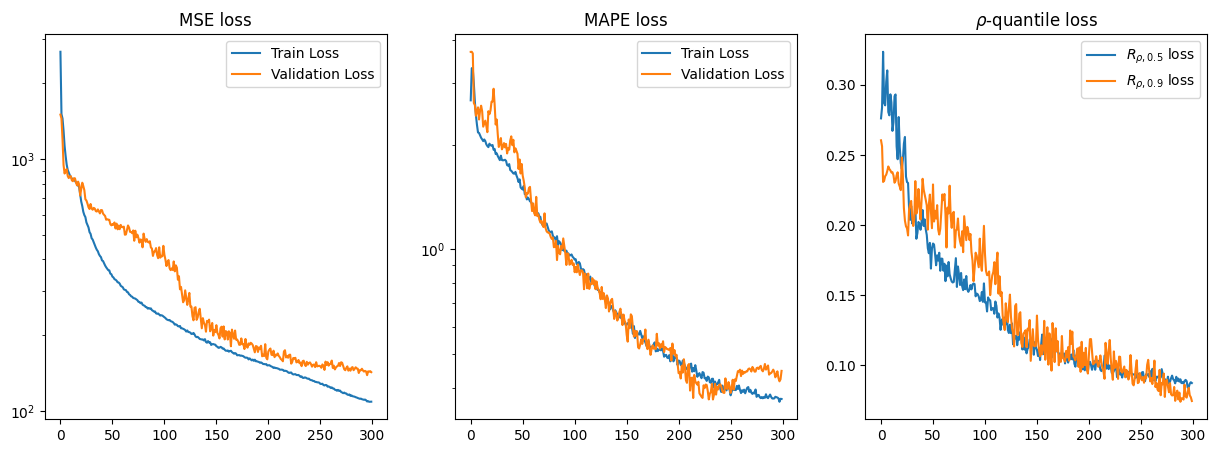

In [7]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [8]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(144.2558651123047,
 0.4292309260368347,
 [0.08765087276697159, 0.0722360759973526])

### N-step prediction

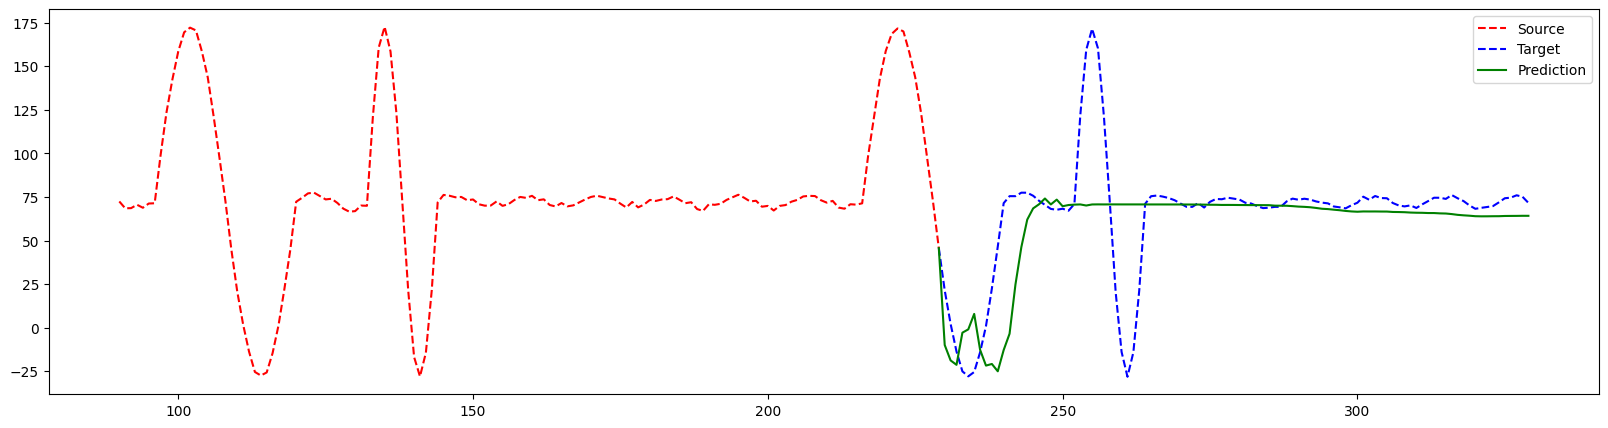

In [13]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

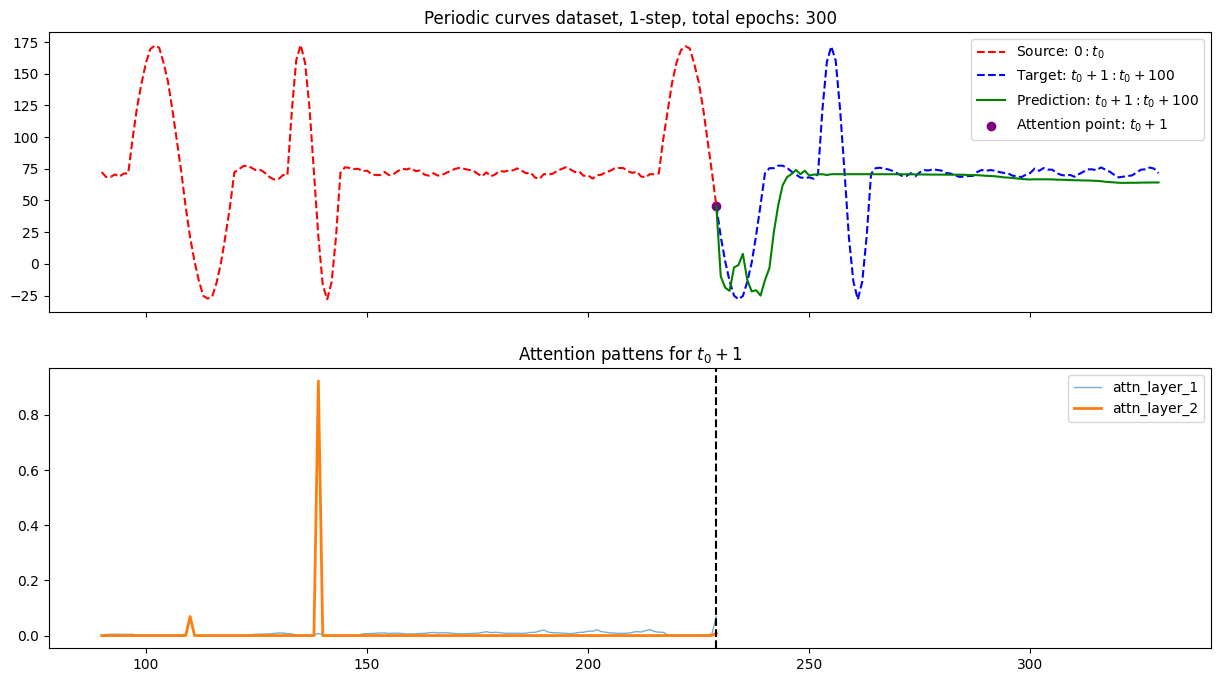

In [10]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

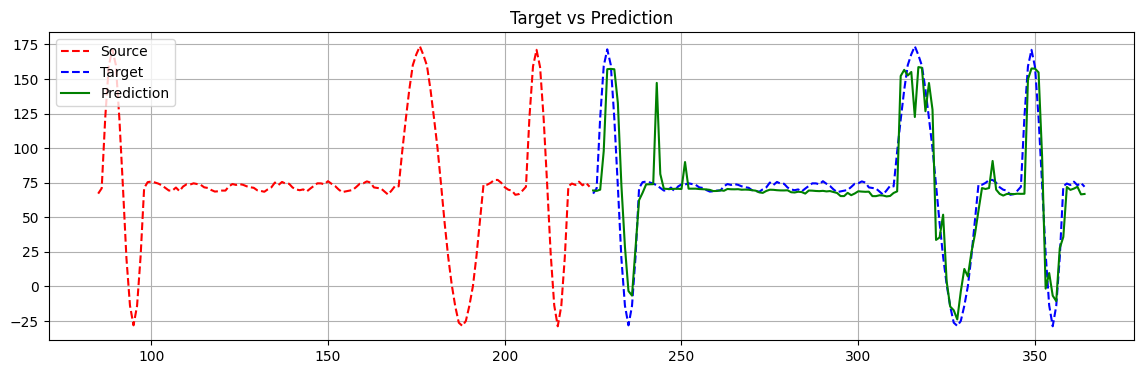

In [28]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 2: One-step and N-step prediction using *two heads* and the *euclidean* distance function.

### Training setup

In [ ]:
n_heads = 2                               # Number of heads used in multi headed simplex attention
distance_metric = euclidean                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [ ]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2663.2660	val_loss=1500.5442	train_mape_loss=2.6795	val_mape_loss=3.6920	R_p=['0.2761', '0.2604']
epoch=1	train_loss=1507.3006	val_loss=1447.7305	train_mape_loss=3.3150	val_mape_loss=3.6944	R_p=['0.2839', '0.2562']
epoch=2	train_loss=1448.1370	val_loss=1199.7665	train_mape_loss=3.2861	val_mape_loss=3.6533	R_p=['0.3235', '0.2308']
epoch=3	train_loss=1297.3303	val_loss=947.3216	train_mape_loss=2.9888	val_mape_loss=2.6320	R_p=['0.2870', '0.2316']
epoch=4	train_loss=1127.7603	val_loss=876.2465	train_mape_loss=2.6491	val_mape_loss=2.5955	R_p=['0.2853', '0.2349']
epoch=5	train_loss=1027.6757	val_loss=899.5300	train_mape_loss=2.4253	val_mape_loss=2.4188	R_p=['0.3022', '0.2359']
epoch=6	train_loss=951.7864	val_loss=912.4815	train_mape_loss=2.2787	val_mape_loss=2.4926	R_p=['0.3103', '0.2385']
epoch=7	train_loss=905.1691	val_loss=857.2501	train_mape_loss=2.1667	val_mape_loss=2.5582	R_p=['0.2806', '0.2418']
epoch=8	train_loss=885.1344	val_loss=840.8625	train_mape_loss=2.1594	va

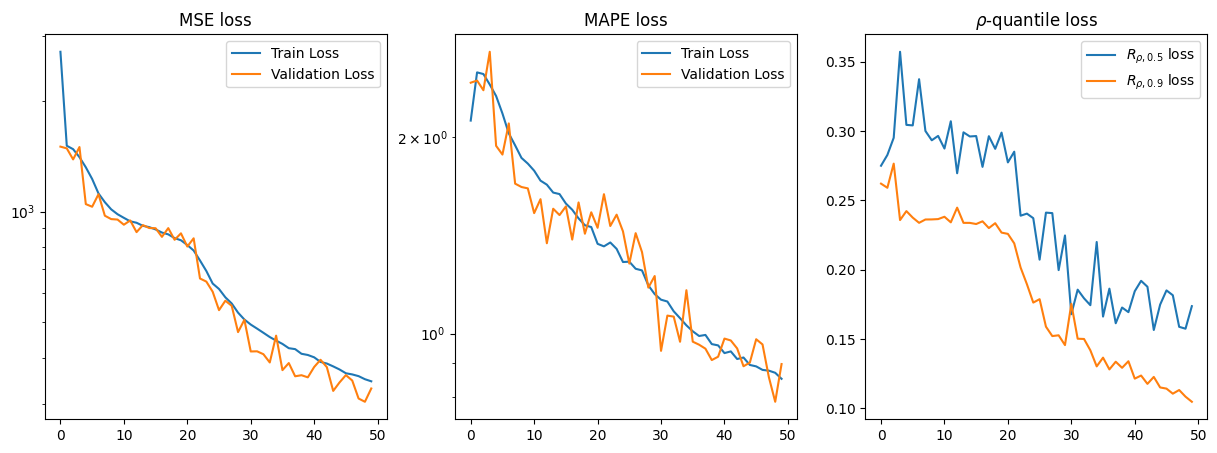

In [ ]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [ ]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(337.9434448242188,
 0.9549539384841919,
 [0.1756848692893982, 0.10639981180429459])

### N-step prediction

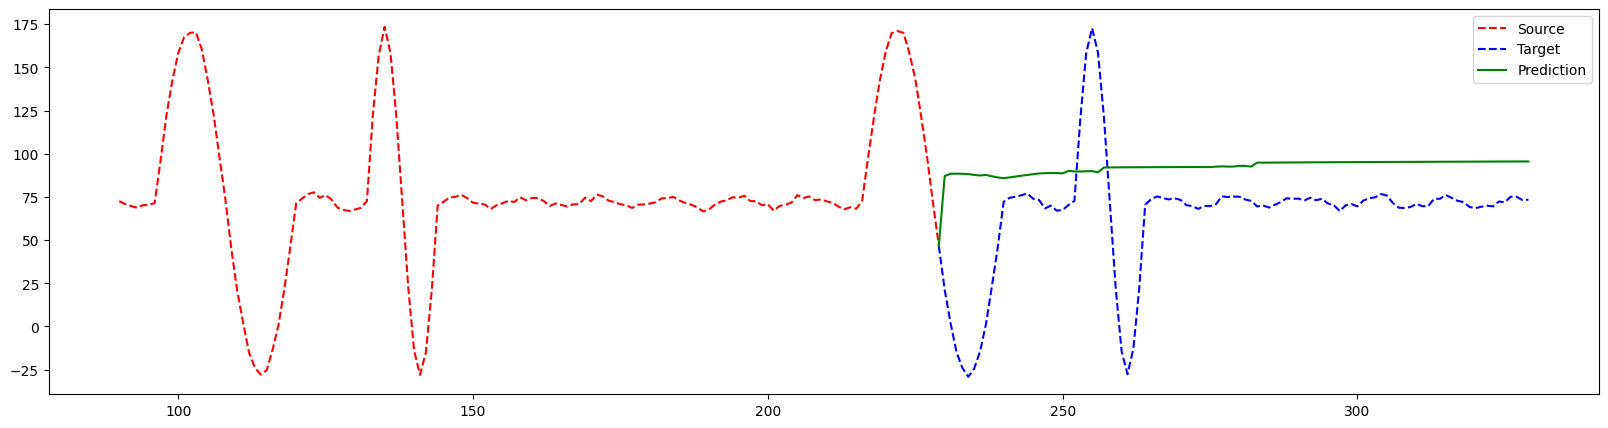

In [ ]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

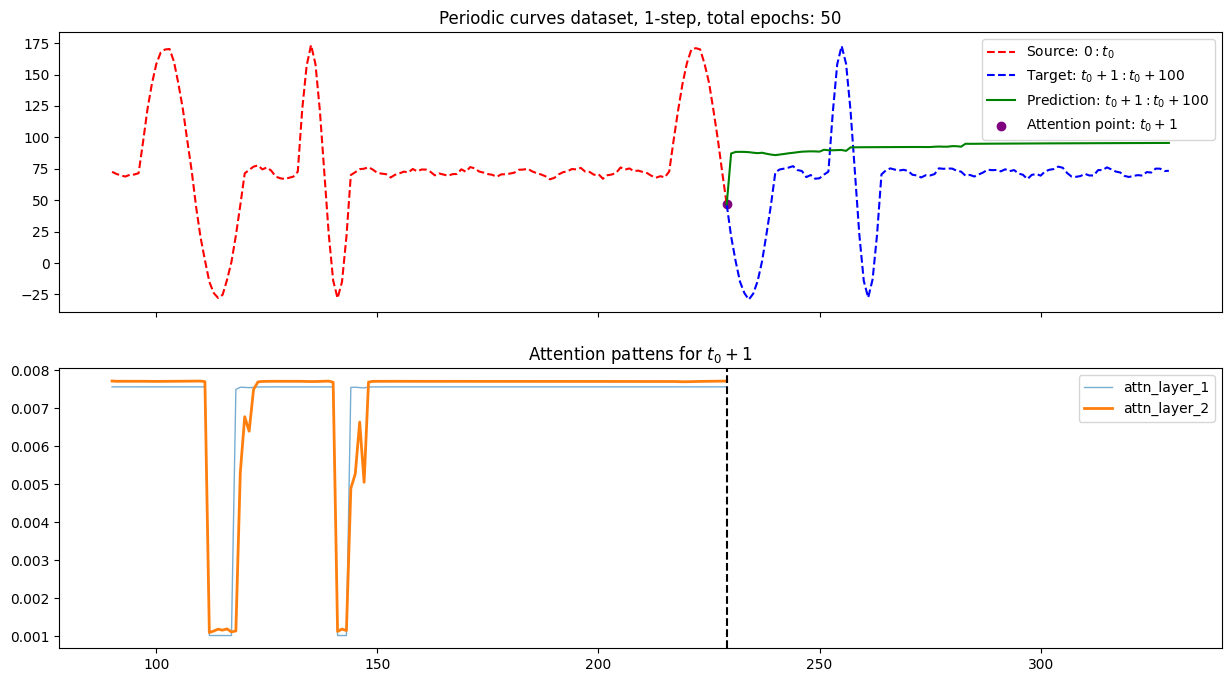

In [ ]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

In [ ]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 3: One-step and N-step prediction using *three heads* and the *euclidean* distance function.

### Training setup

In [ ]:
n_heads = 3                               # Number of heads used in multi headed simplex attention
distance_metric = euclidean                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [ ]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2663.2660	val_loss=1500.5442	train_mape_loss=2.6795	val_mape_loss=3.6920	R_p=['0.2761', '0.2604']
epoch=1	train_loss=1507.3006	val_loss=1447.7305	train_mape_loss=3.3150	val_mape_loss=3.6944	R_p=['0.2839', '0.2562']
epoch=2	train_loss=1448.1370	val_loss=1199.7665	train_mape_loss=3.2861	val_mape_loss=3.6533	R_p=['0.3235', '0.2308']
epoch=3	train_loss=1297.3303	val_loss=947.3216	train_mape_loss=2.9888	val_mape_loss=2.6320	R_p=['0.2870', '0.2316']
epoch=4	train_loss=1127.7603	val_loss=876.2465	train_mape_loss=2.6491	val_mape_loss=2.5955	R_p=['0.2853', '0.2349']
epoch=5	train_loss=1027.6757	val_loss=899.5300	train_mape_loss=2.4253	val_mape_loss=2.4188	R_p=['0.3022', '0.2359']
epoch=6	train_loss=951.7864	val_loss=912.4815	train_mape_loss=2.2787	val_mape_loss=2.4926	R_p=['0.3103', '0.2385']
epoch=7	train_loss=905.1691	val_loss=857.2501	train_mape_loss=2.1667	val_mape_loss=2.5582	R_p=['0.2806', '0.2418']
epoch=8	train_loss=885.1344	val_loss=840.8625	train_mape_loss=2.1594	va

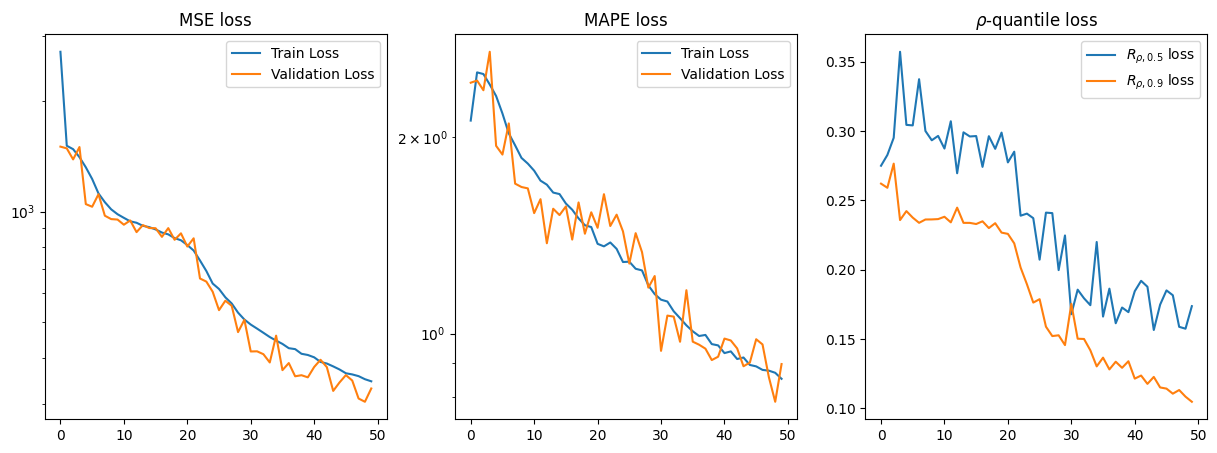

In [ ]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [ ]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(337.9434448242188,
 0.9549539384841919,
 [0.1756848692893982, 0.10639981180429459])

### N-step prediction

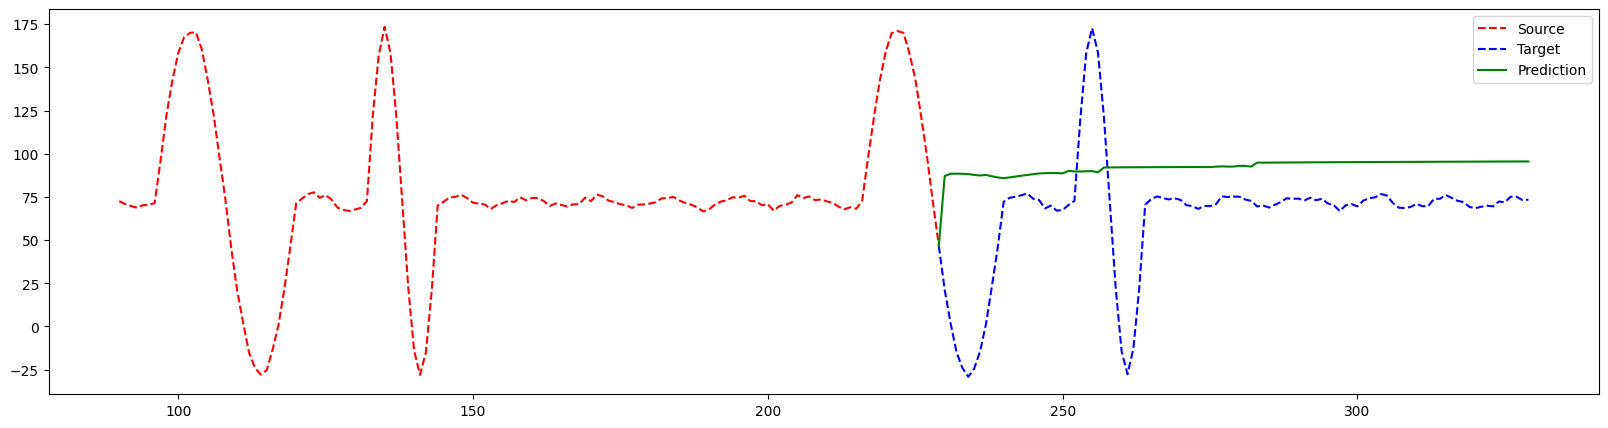

In [ ]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

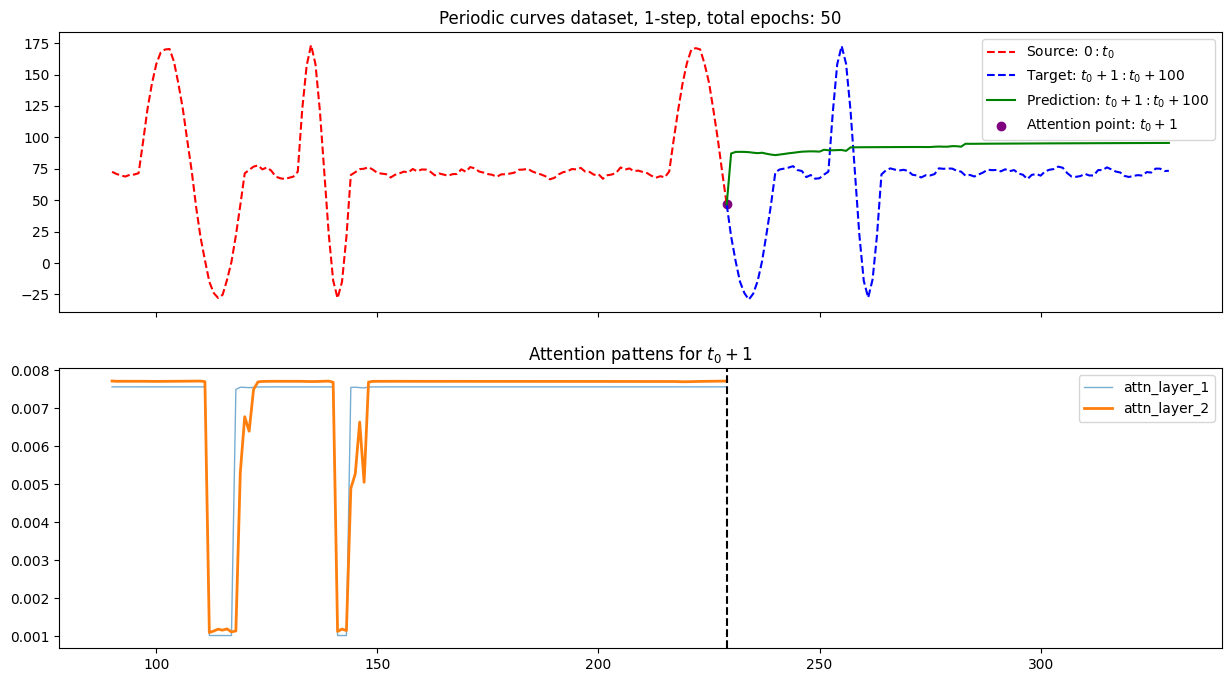

In [ ]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

In [ ]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 4: One-step and N-step prediction using *four heads* and the *euclidean* distance function.

### Training setup

In [ ]:
n_heads = 4                               # Number of heads used in multi headed simplex attention
distance_metric = euclidean                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [ ]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2663.2660	val_loss=1500.5442	train_mape_loss=2.6795	val_mape_loss=3.6920	R_p=['0.2761', '0.2604']
epoch=1	train_loss=1507.3006	val_loss=1447.7305	train_mape_loss=3.3150	val_mape_loss=3.6944	R_p=['0.2839', '0.2562']
epoch=2	train_loss=1448.1370	val_loss=1199.7665	train_mape_loss=3.2861	val_mape_loss=3.6533	R_p=['0.3235', '0.2308']
epoch=3	train_loss=1297.3303	val_loss=947.3216	train_mape_loss=2.9888	val_mape_loss=2.6320	R_p=['0.2870', '0.2316']
epoch=4	train_loss=1127.7603	val_loss=876.2465	train_mape_loss=2.6491	val_mape_loss=2.5955	R_p=['0.2853', '0.2349']
epoch=5	train_loss=1027.6757	val_loss=899.5300	train_mape_loss=2.4253	val_mape_loss=2.4188	R_p=['0.3022', '0.2359']
epoch=6	train_loss=951.7864	val_loss=912.4815	train_mape_loss=2.2787	val_mape_loss=2.4926	R_p=['0.3103', '0.2385']
epoch=7	train_loss=905.1691	val_loss=857.2501	train_mape_loss=2.1667	val_mape_loss=2.5582	R_p=['0.2806', '0.2418']
epoch=8	train_loss=885.1344	val_loss=840.8625	train_mape_loss=2.1594	va

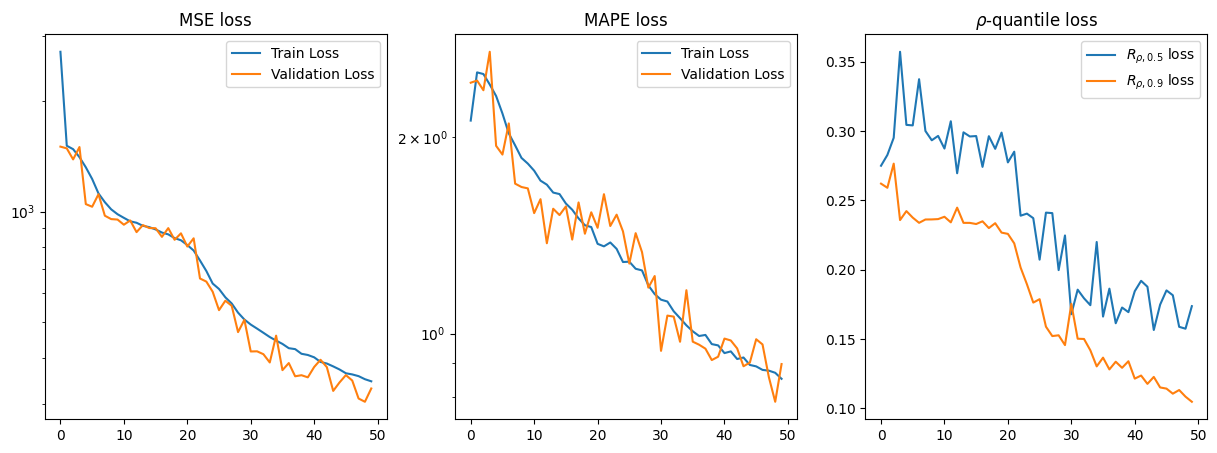

In [ ]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [ ]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(337.9434448242188,
 0.9549539384841919,
 [0.1756848692893982, 0.10639981180429459])

### N-step prediction

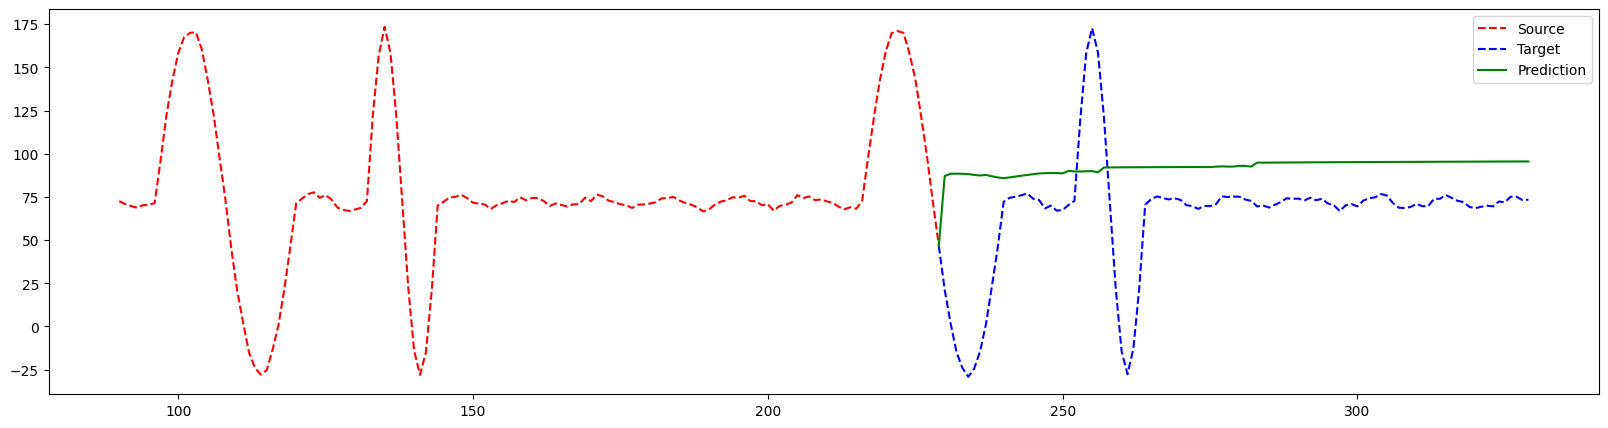

In [ ]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

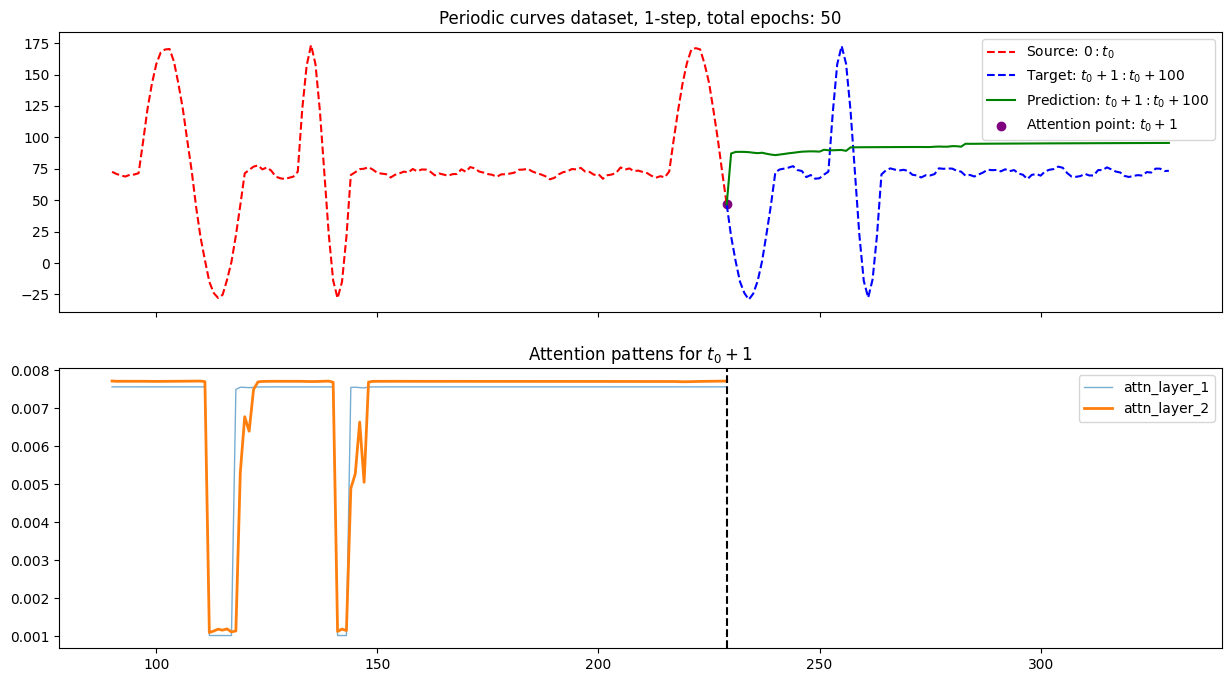

In [ ]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

In [ ]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 5: One-step and N-step prediction using *one head* and the *cosine* distance function.

### Training setup

In [ ]:
n_heads = 1                               # Number of heads used in multi headed simplex attention
distance_metric = cosine                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [ ]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2663.2660	val_loss=1500.5442	train_mape_loss=2.6795	val_mape_loss=3.6920	R_p=['0.2761', '0.2604']
epoch=1	train_loss=1507.3006	val_loss=1447.7305	train_mape_loss=3.3150	val_mape_loss=3.6944	R_p=['0.2839', '0.2562']
epoch=2	train_loss=1448.1370	val_loss=1199.7665	train_mape_loss=3.2861	val_mape_loss=3.6533	R_p=['0.3235', '0.2308']
epoch=3	train_loss=1297.3303	val_loss=947.3216	train_mape_loss=2.9888	val_mape_loss=2.6320	R_p=['0.2870', '0.2316']
epoch=4	train_loss=1127.7603	val_loss=876.2465	train_mape_loss=2.6491	val_mape_loss=2.5955	R_p=['0.2853', '0.2349']
epoch=5	train_loss=1027.6757	val_loss=899.5300	train_mape_loss=2.4253	val_mape_loss=2.4188	R_p=['0.3022', '0.2359']
epoch=6	train_loss=951.7864	val_loss=912.4815	train_mape_loss=2.2787	val_mape_loss=2.4926	R_p=['0.3103', '0.2385']
epoch=7	train_loss=905.1691	val_loss=857.2501	train_mape_loss=2.1667	val_mape_loss=2.5582	R_p=['0.2806', '0.2418']
epoch=8	train_loss=885.1344	val_loss=840.8625	train_mape_loss=2.1594	va

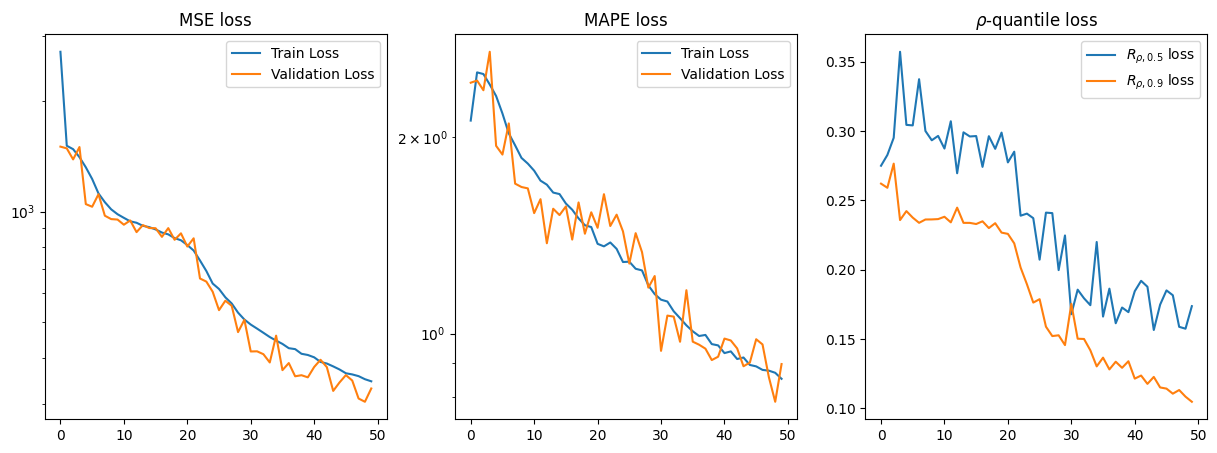

In [ ]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [ ]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(337.9434448242188,
 0.9549539384841919,
 [0.1756848692893982, 0.10639981180429459])

### N-step prediction

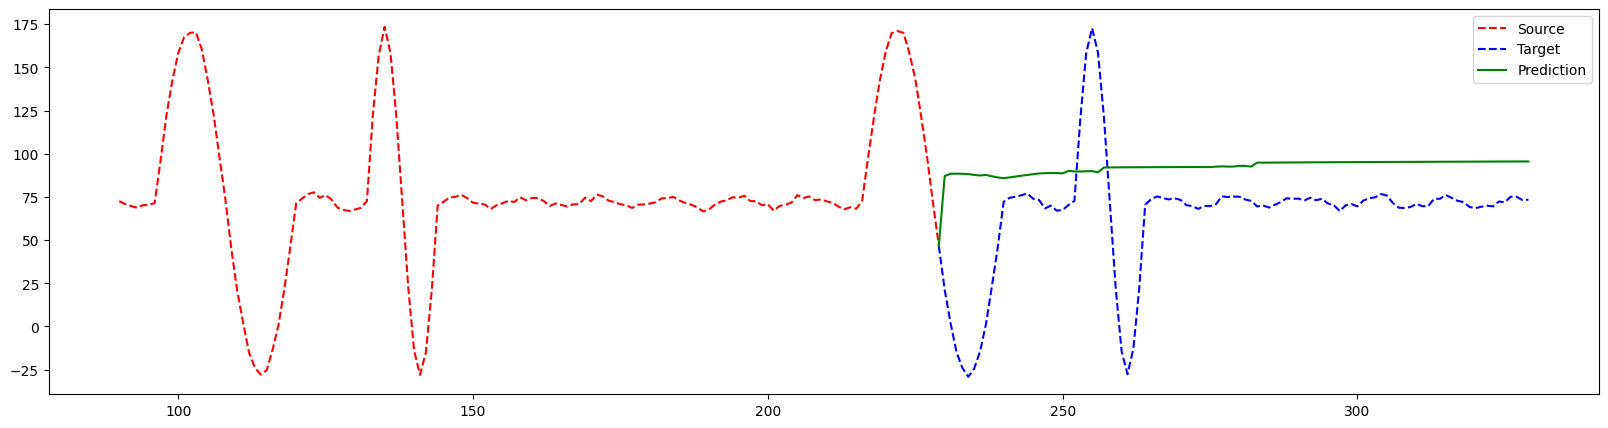

In [ ]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

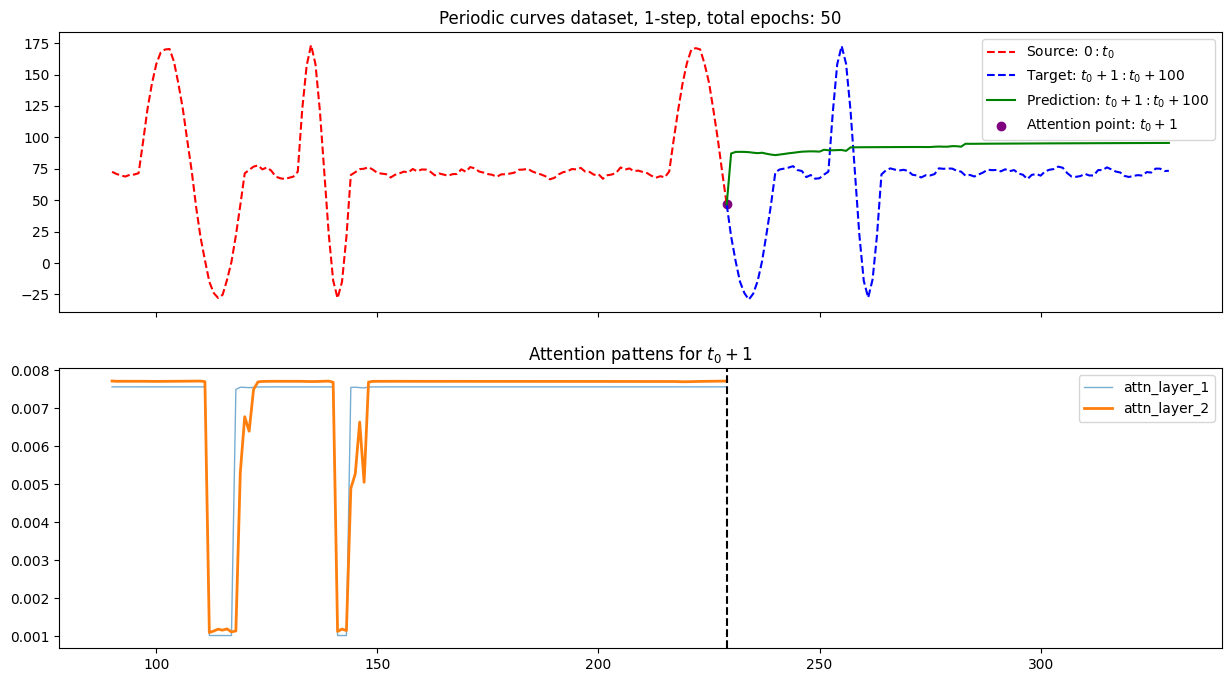

In [ ]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

In [ ]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 6: One-step and N-step prediction using *two heads* and the *cosine* distance function.

### Training setup

In [ ]:
n_heads = 2                               # Number of heads used in multi headed simplex attention
distance_metric = cosine                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [ ]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2663.2660	val_loss=1500.5442	train_mape_loss=2.6795	val_mape_loss=3.6920	R_p=['0.2761', '0.2604']
epoch=1	train_loss=1507.3006	val_loss=1447.7305	train_mape_loss=3.3150	val_mape_loss=3.6944	R_p=['0.2839', '0.2562']
epoch=2	train_loss=1448.1370	val_loss=1199.7665	train_mape_loss=3.2861	val_mape_loss=3.6533	R_p=['0.3235', '0.2308']
epoch=3	train_loss=1297.3303	val_loss=947.3216	train_mape_loss=2.9888	val_mape_loss=2.6320	R_p=['0.2870', '0.2316']
epoch=4	train_loss=1127.7603	val_loss=876.2465	train_mape_loss=2.6491	val_mape_loss=2.5955	R_p=['0.2853', '0.2349']
epoch=5	train_loss=1027.6757	val_loss=899.5300	train_mape_loss=2.4253	val_mape_loss=2.4188	R_p=['0.3022', '0.2359']
epoch=6	train_loss=951.7864	val_loss=912.4815	train_mape_loss=2.2787	val_mape_loss=2.4926	R_p=['0.3103', '0.2385']
epoch=7	train_loss=905.1691	val_loss=857.2501	train_mape_loss=2.1667	val_mape_loss=2.5582	R_p=['0.2806', '0.2418']
epoch=8	train_loss=885.1344	val_loss=840.8625	train_mape_loss=2.1594	va

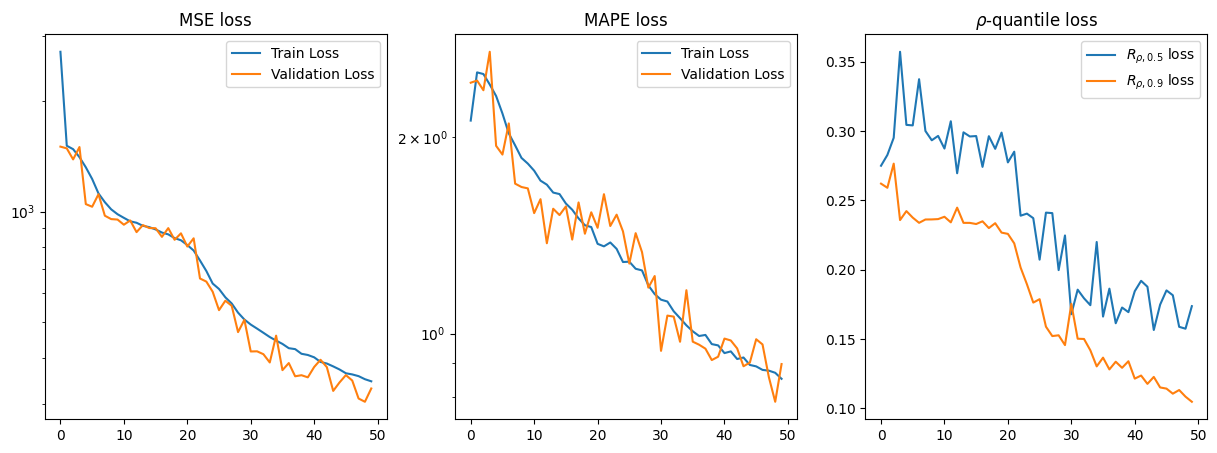

In [ ]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [ ]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(337.9434448242188,
 0.9549539384841919,
 [0.1756848692893982, 0.10639981180429459])

### N-step prediction

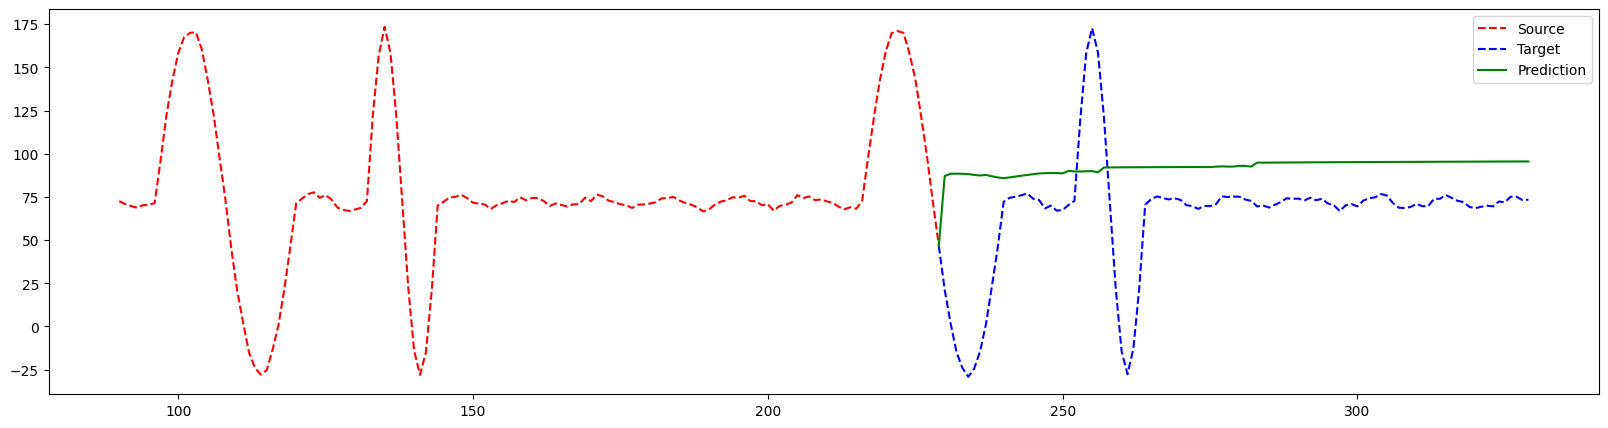

In [ ]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

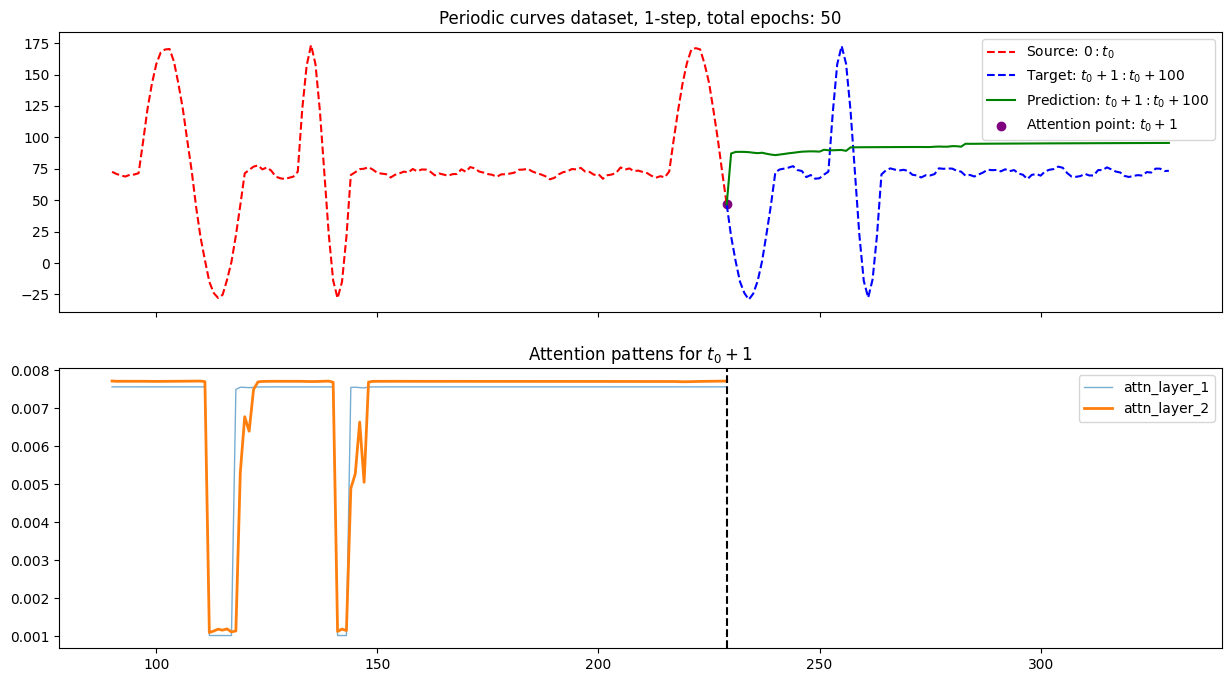

In [ ]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

In [ ]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 7: One-step and N-step prediction using *three heads* and the *cosine* distance function.

### Training setup

In [ ]:
n_heads = 3                               # Number of heads used in multi headed simplex attention
distance_metric = cosine                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [ ]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2663.2660	val_loss=1500.5442	train_mape_loss=2.6795	val_mape_loss=3.6920	R_p=['0.2761', '0.2604']
epoch=1	train_loss=1507.3006	val_loss=1447.7305	train_mape_loss=3.3150	val_mape_loss=3.6944	R_p=['0.2839', '0.2562']
epoch=2	train_loss=1448.1370	val_loss=1199.7665	train_mape_loss=3.2861	val_mape_loss=3.6533	R_p=['0.3235', '0.2308']
epoch=3	train_loss=1297.3303	val_loss=947.3216	train_mape_loss=2.9888	val_mape_loss=2.6320	R_p=['0.2870', '0.2316']
epoch=4	train_loss=1127.7603	val_loss=876.2465	train_mape_loss=2.6491	val_mape_loss=2.5955	R_p=['0.2853', '0.2349']
epoch=5	train_loss=1027.6757	val_loss=899.5300	train_mape_loss=2.4253	val_mape_loss=2.4188	R_p=['0.3022', '0.2359']
epoch=6	train_loss=951.7864	val_loss=912.4815	train_mape_loss=2.2787	val_mape_loss=2.4926	R_p=['0.3103', '0.2385']
epoch=7	train_loss=905.1691	val_loss=857.2501	train_mape_loss=2.1667	val_mape_loss=2.5582	R_p=['0.2806', '0.2418']
epoch=8	train_loss=885.1344	val_loss=840.8625	train_mape_loss=2.1594	va

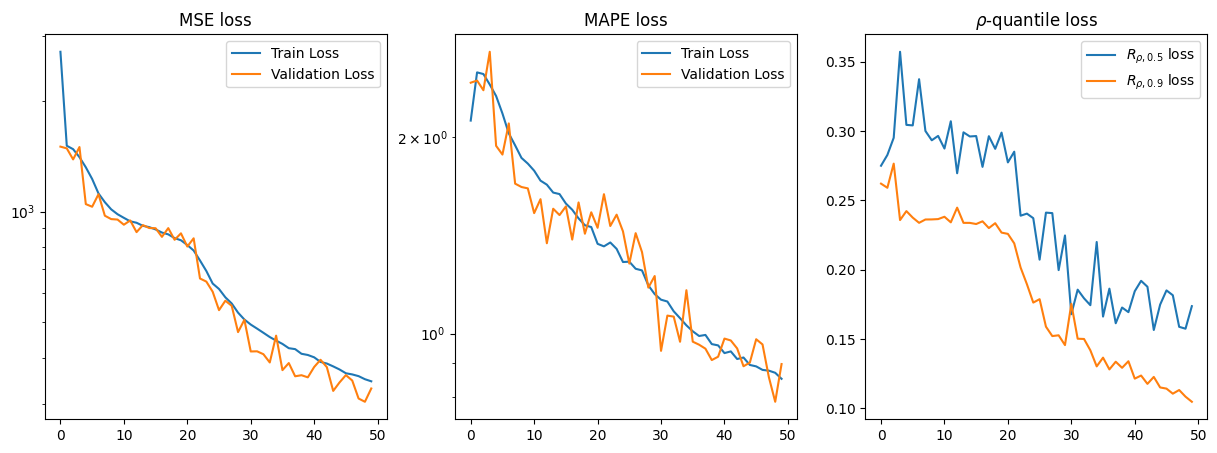

In [ ]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [ ]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(337.9434448242188,
 0.9549539384841919,
 [0.1756848692893982, 0.10639981180429459])

### N-step prediction

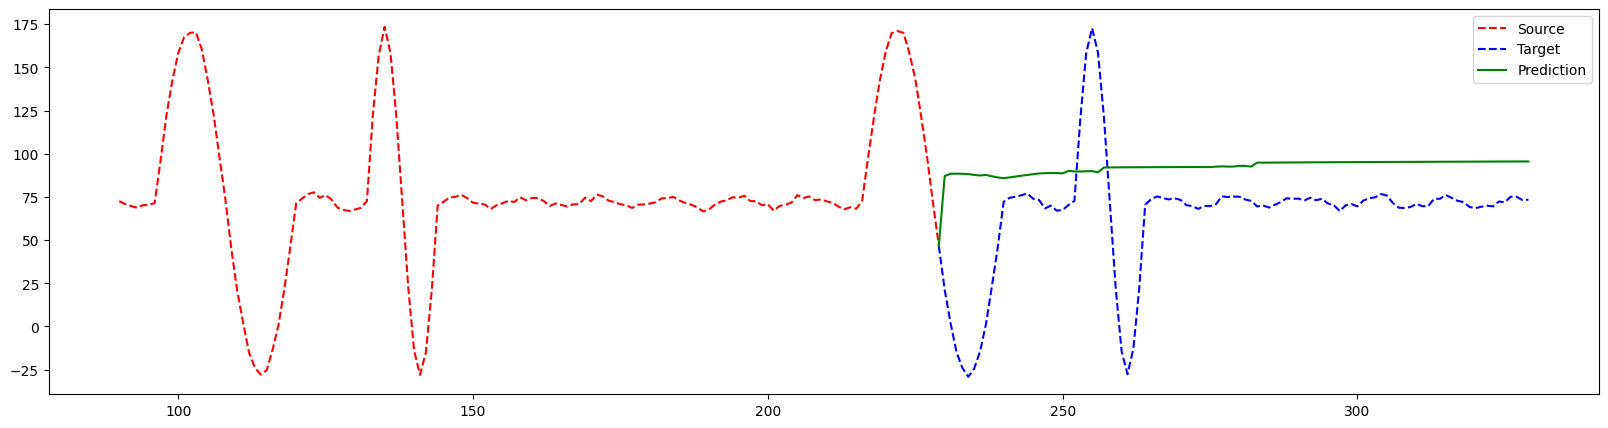

In [ ]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

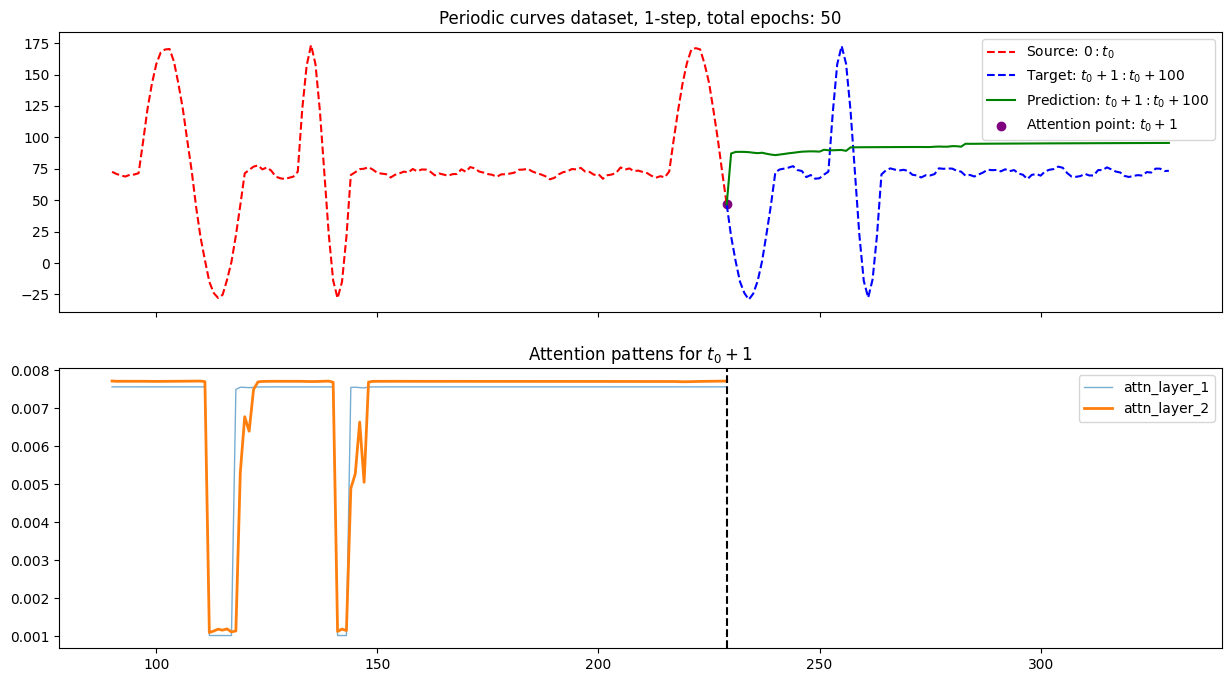

In [ ]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

In [ ]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 8: One-step and N-step prediction using *four heads* and the *cosine* distance function.

### Training setup

In [ ]:
n_heads = 4                               # Number of heads used in multi headed simplex attention
distance_metric = cosine                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [ ]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2663.2660	val_loss=1500.5442	train_mape_loss=2.6795	val_mape_loss=3.6920	R_p=['0.2761', '0.2604']
epoch=1	train_loss=1507.3006	val_loss=1447.7305	train_mape_loss=3.3150	val_mape_loss=3.6944	R_p=['0.2839', '0.2562']
epoch=2	train_loss=1448.1370	val_loss=1199.7665	train_mape_loss=3.2861	val_mape_loss=3.6533	R_p=['0.3235', '0.2308']
epoch=3	train_loss=1297.3303	val_loss=947.3216	train_mape_loss=2.9888	val_mape_loss=2.6320	R_p=['0.2870', '0.2316']
epoch=4	train_loss=1127.7603	val_loss=876.2465	train_mape_loss=2.6491	val_mape_loss=2.5955	R_p=['0.2853', '0.2349']
epoch=5	train_loss=1027.6757	val_loss=899.5300	train_mape_loss=2.4253	val_mape_loss=2.4188	R_p=['0.3022', '0.2359']
epoch=6	train_loss=951.7864	val_loss=912.4815	train_mape_loss=2.2787	val_mape_loss=2.4926	R_p=['0.3103', '0.2385']
epoch=7	train_loss=905.1691	val_loss=857.2501	train_mape_loss=2.1667	val_mape_loss=2.5582	R_p=['0.2806', '0.2418']
epoch=8	train_loss=885.1344	val_loss=840.8625	train_mape_loss=2.1594	va

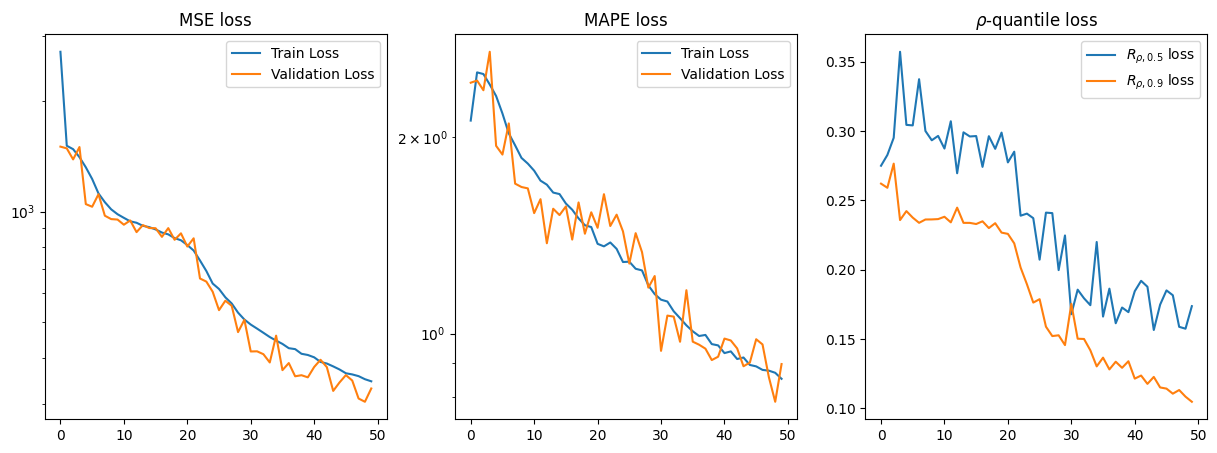

In [ ]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [ ]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(337.9434448242188,
 0.9549539384841919,
 [0.1756848692893982, 0.10639981180429459])

### N-step prediction

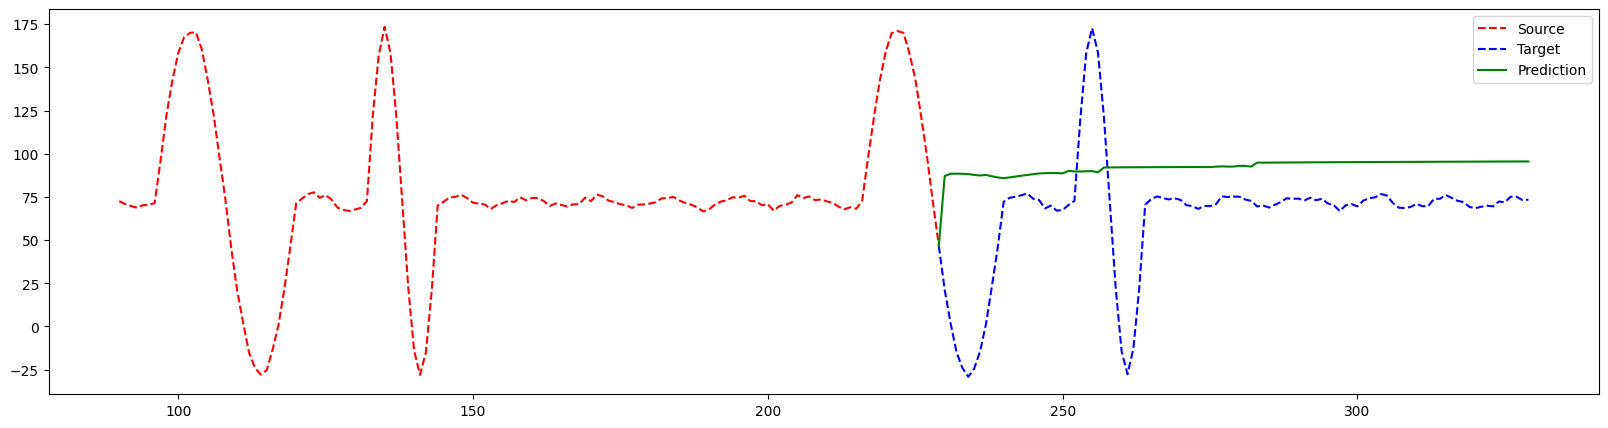

In [ ]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

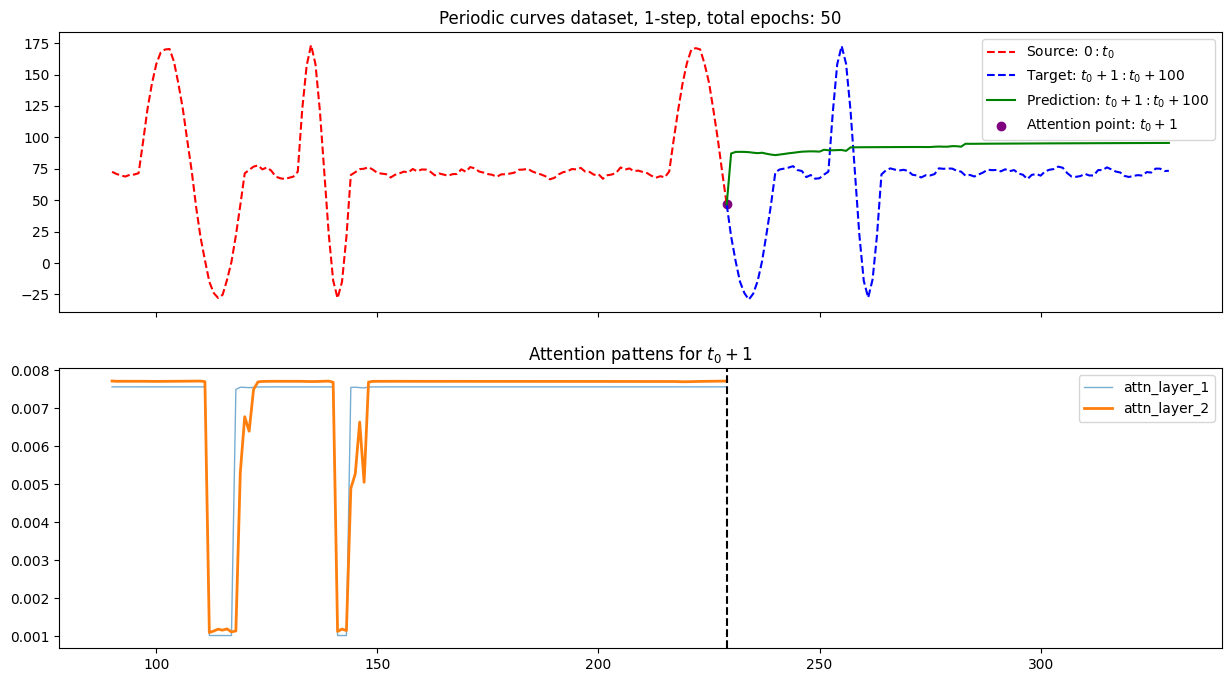

In [ ]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

In [ ]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 9: One-step and N-step prediction using *one head* and the *manhatten* distance function.

### Training setup

In [ ]:
n_heads = 1                               # Number of heads used in multi headed simplex attention
distance_metric = manhattan                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [ ]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2663.2660	val_loss=1500.5442	train_mape_loss=2.6795	val_mape_loss=3.6920	R_p=['0.2761', '0.2604']
epoch=1	train_loss=1507.3006	val_loss=1447.7305	train_mape_loss=3.3150	val_mape_loss=3.6944	R_p=['0.2839', '0.2562']
epoch=2	train_loss=1448.1370	val_loss=1199.7665	train_mape_loss=3.2861	val_mape_loss=3.6533	R_p=['0.3235', '0.2308']
epoch=3	train_loss=1297.3303	val_loss=947.3216	train_mape_loss=2.9888	val_mape_loss=2.6320	R_p=['0.2870', '0.2316']
epoch=4	train_loss=1127.7603	val_loss=876.2465	train_mape_loss=2.6491	val_mape_loss=2.5955	R_p=['0.2853', '0.2349']
epoch=5	train_loss=1027.6757	val_loss=899.5300	train_mape_loss=2.4253	val_mape_loss=2.4188	R_p=['0.3022', '0.2359']
epoch=6	train_loss=951.7864	val_loss=912.4815	train_mape_loss=2.2787	val_mape_loss=2.4926	R_p=['0.3103', '0.2385']
epoch=7	train_loss=905.1691	val_loss=857.2501	train_mape_loss=2.1667	val_mape_loss=2.5582	R_p=['0.2806', '0.2418']
epoch=8	train_loss=885.1344	val_loss=840.8625	train_mape_loss=2.1594	va

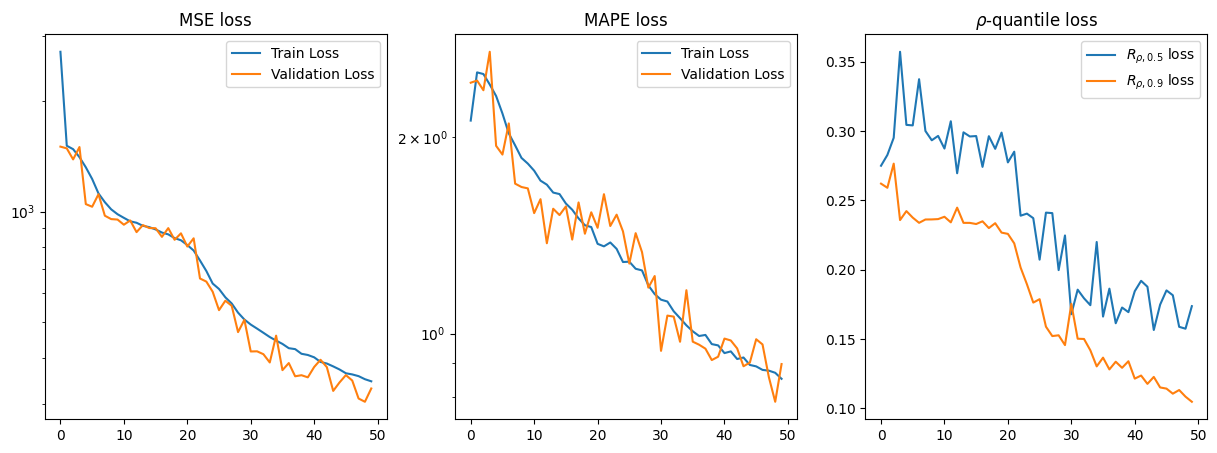

In [ ]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [ ]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(337.9434448242188,
 0.9549539384841919,
 [0.1756848692893982, 0.10639981180429459])

### N-step prediction

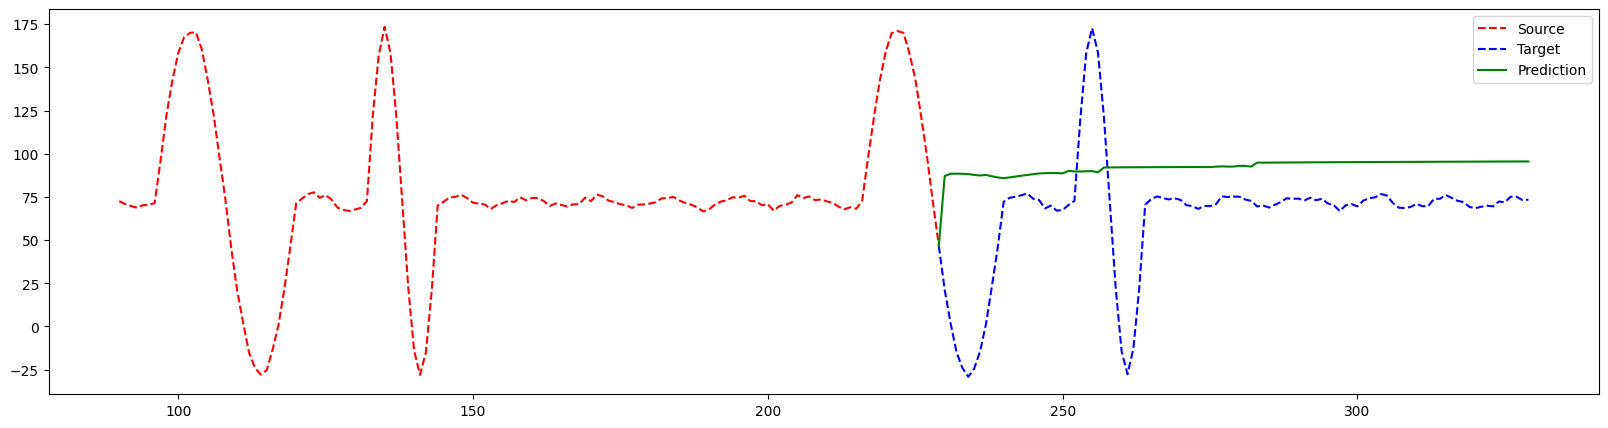

In [ ]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

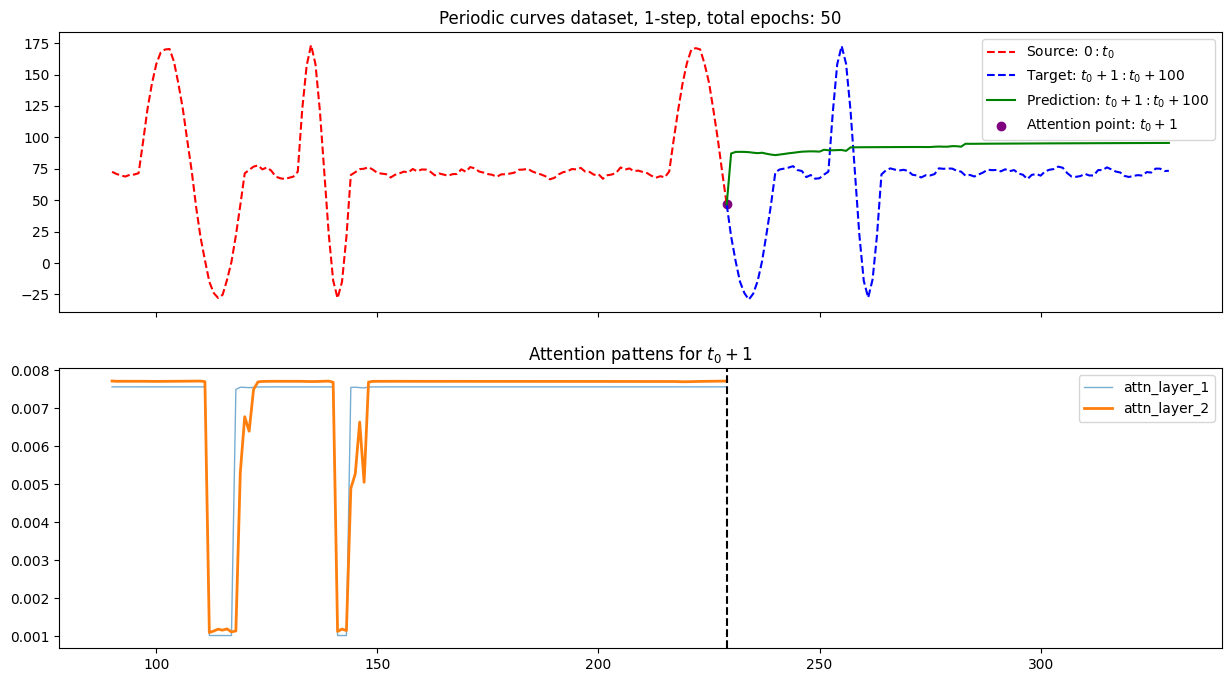

In [ ]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

In [ ]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 10: One-step and N-step prediction using *two heads* and the *manattan* distance function.

### Training setup

In [ ]:
n_heads = 2                               # Number of heads used in multi headed simplex attention
distance_metric = manhattan                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [ ]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2663.2660	val_loss=1500.5442	train_mape_loss=2.6795	val_mape_loss=3.6920	R_p=['0.2761', '0.2604']
epoch=1	train_loss=1507.3006	val_loss=1447.7305	train_mape_loss=3.3150	val_mape_loss=3.6944	R_p=['0.2839', '0.2562']
epoch=2	train_loss=1448.1370	val_loss=1199.7665	train_mape_loss=3.2861	val_mape_loss=3.6533	R_p=['0.3235', '0.2308']
epoch=3	train_loss=1297.3303	val_loss=947.3216	train_mape_loss=2.9888	val_mape_loss=2.6320	R_p=['0.2870', '0.2316']
epoch=4	train_loss=1127.7603	val_loss=876.2465	train_mape_loss=2.6491	val_mape_loss=2.5955	R_p=['0.2853', '0.2349']
epoch=5	train_loss=1027.6757	val_loss=899.5300	train_mape_loss=2.4253	val_mape_loss=2.4188	R_p=['0.3022', '0.2359']
epoch=6	train_loss=951.7864	val_loss=912.4815	train_mape_loss=2.2787	val_mape_loss=2.4926	R_p=['0.3103', '0.2385']
epoch=7	train_loss=905.1691	val_loss=857.2501	train_mape_loss=2.1667	val_mape_loss=2.5582	R_p=['0.2806', '0.2418']
epoch=8	train_loss=885.1344	val_loss=840.8625	train_mape_loss=2.1594	va

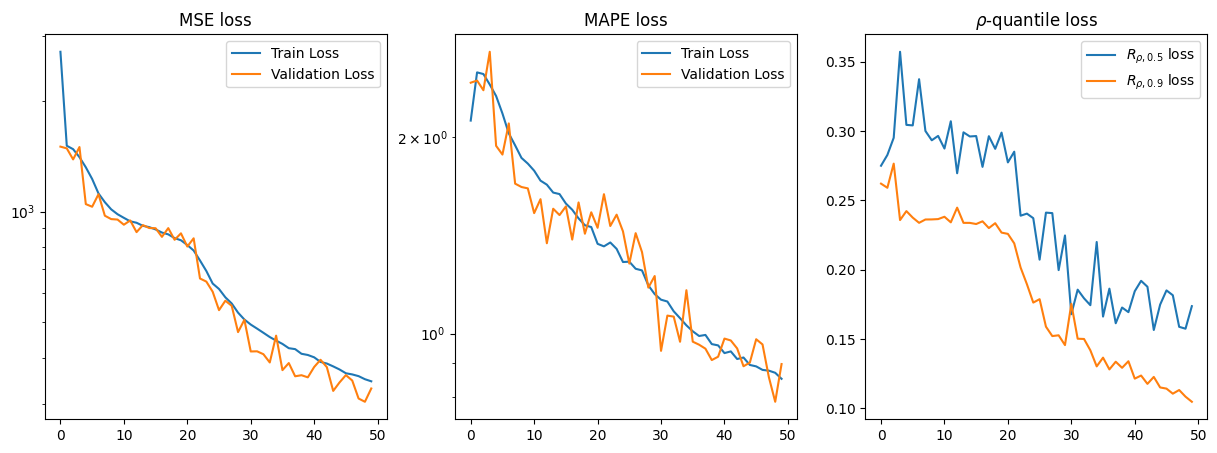

In [ ]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [ ]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(337.9434448242188,
 0.9549539384841919,
 [0.1756848692893982, 0.10639981180429459])

### N-step prediction

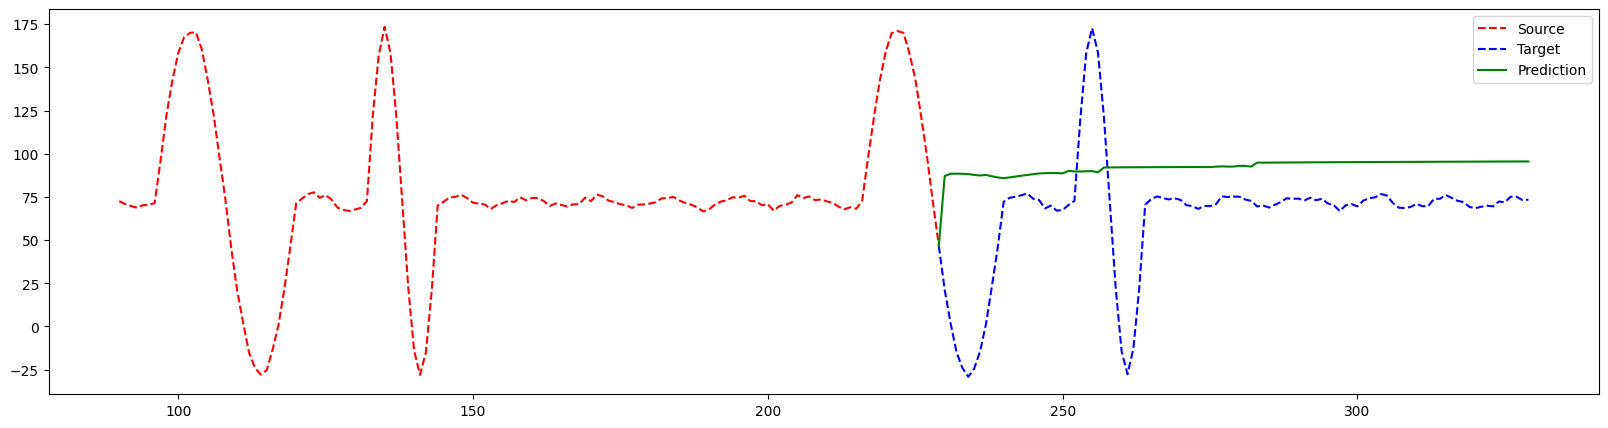

In [ ]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

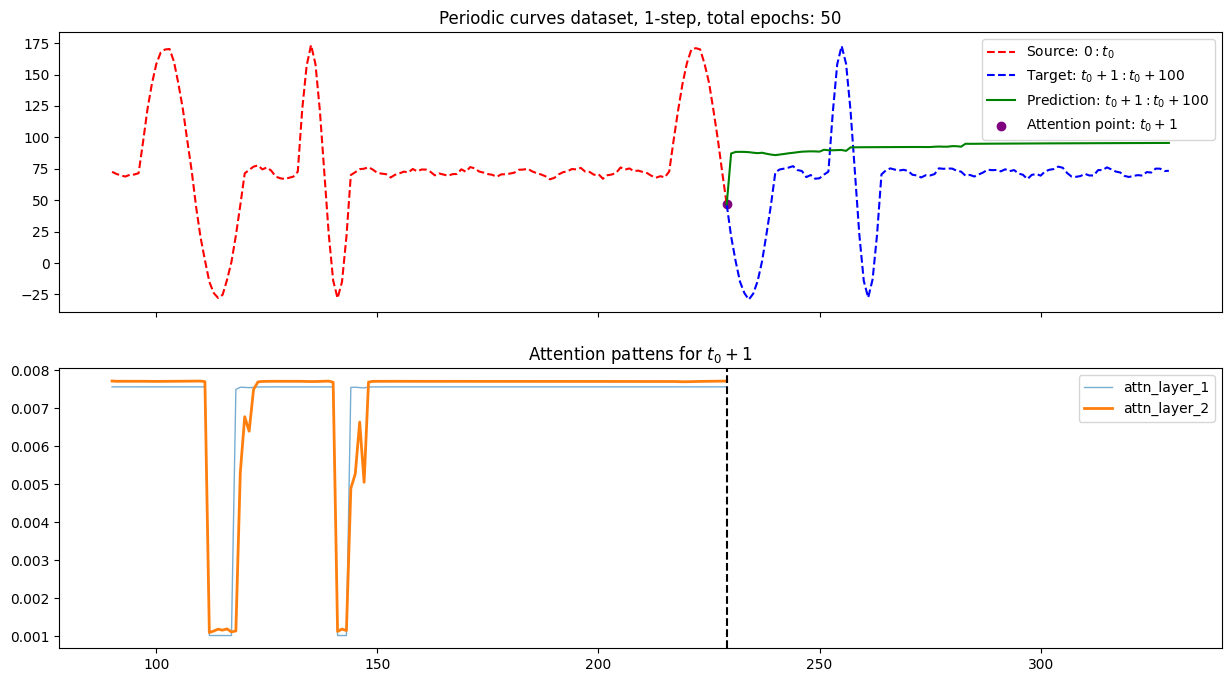

In [ ]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

In [ ]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 11: One-step and N-step prediction using *three heads* and the *manattan* distance function.

In [ ]:
n_heads = 3                               # Number of heads used in multi headed simplex attention
distance_metric = manhattan                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [ ]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2663.2660	val_loss=1500.5442	train_mape_loss=2.6795	val_mape_loss=3.6920	R_p=['0.2761', '0.2604']
epoch=1	train_loss=1507.3006	val_loss=1447.7305	train_mape_loss=3.3150	val_mape_loss=3.6944	R_p=['0.2839', '0.2562']
epoch=2	train_loss=1448.1370	val_loss=1199.7665	train_mape_loss=3.2861	val_mape_loss=3.6533	R_p=['0.3235', '0.2308']
epoch=3	train_loss=1297.3303	val_loss=947.3216	train_mape_loss=2.9888	val_mape_loss=2.6320	R_p=['0.2870', '0.2316']
epoch=4	train_loss=1127.7603	val_loss=876.2465	train_mape_loss=2.6491	val_mape_loss=2.5955	R_p=['0.2853', '0.2349']
epoch=5	train_loss=1027.6757	val_loss=899.5300	train_mape_loss=2.4253	val_mape_loss=2.4188	R_p=['0.3022', '0.2359']
epoch=6	train_loss=951.7864	val_loss=912.4815	train_mape_loss=2.2787	val_mape_loss=2.4926	R_p=['0.3103', '0.2385']
epoch=7	train_loss=905.1691	val_loss=857.2501	train_mape_loss=2.1667	val_mape_loss=2.5582	R_p=['0.2806', '0.2418']
epoch=8	train_loss=885.1344	val_loss=840.8625	train_mape_loss=2.1594	va

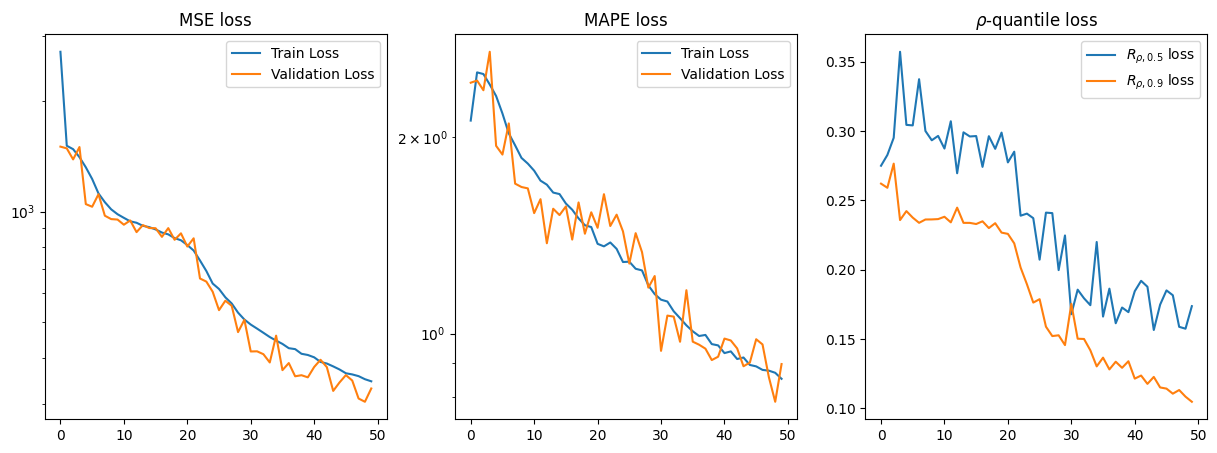

In [ ]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [ ]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(337.9434448242188,
 0.9549539384841919,
 [0.1756848692893982, 0.10639981180429459])

### N-step prediction

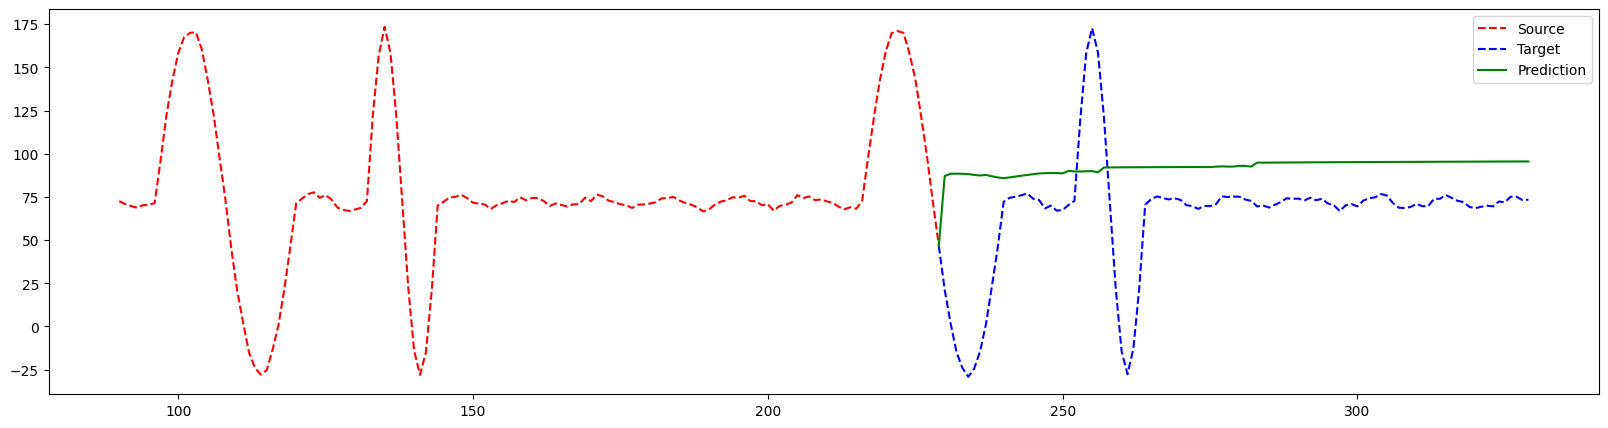

In [ ]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

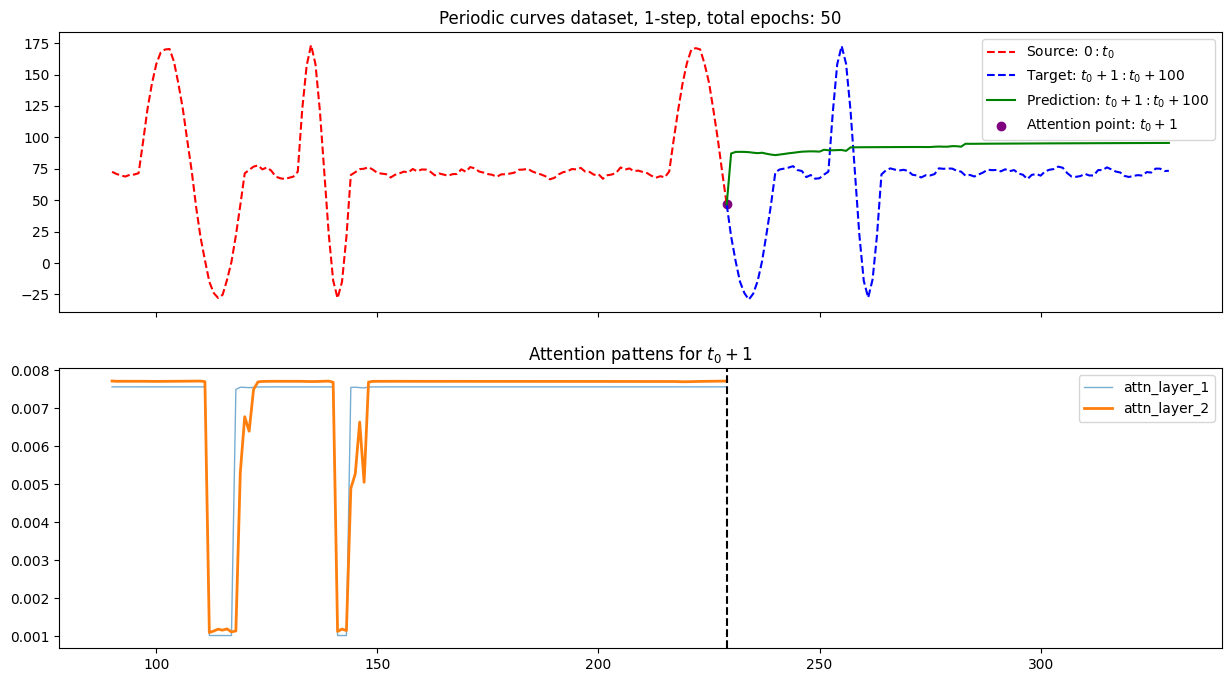

In [ ]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

In [ ]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 12: One-step and N-step prediction using *four heads* and the *manattan* distance function.

In [ ]:
n_heads = 4                               # Number of heads used in multi headed simplex attention
distance_metric = manhattan                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [ ]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2663.2660	val_loss=1500.5442	train_mape_loss=2.6795	val_mape_loss=3.6920	R_p=['0.2761', '0.2604']
epoch=1	train_loss=1507.3006	val_loss=1447.7305	train_mape_loss=3.3150	val_mape_loss=3.6944	R_p=['0.2839', '0.2562']
epoch=2	train_loss=1448.1370	val_loss=1199.7665	train_mape_loss=3.2861	val_mape_loss=3.6533	R_p=['0.3235', '0.2308']
epoch=3	train_loss=1297.3303	val_loss=947.3216	train_mape_loss=2.9888	val_mape_loss=2.6320	R_p=['0.2870', '0.2316']
epoch=4	train_loss=1127.7603	val_loss=876.2465	train_mape_loss=2.6491	val_mape_loss=2.5955	R_p=['0.2853', '0.2349']
epoch=5	train_loss=1027.6757	val_loss=899.5300	train_mape_loss=2.4253	val_mape_loss=2.4188	R_p=['0.3022', '0.2359']
epoch=6	train_loss=951.7864	val_loss=912.4815	train_mape_loss=2.2787	val_mape_loss=2.4926	R_p=['0.3103', '0.2385']
epoch=7	train_loss=905.1691	val_loss=857.2501	train_mape_loss=2.1667	val_mape_loss=2.5582	R_p=['0.2806', '0.2418']
epoch=8	train_loss=885.1344	val_loss=840.8625	train_mape_loss=2.1594	va

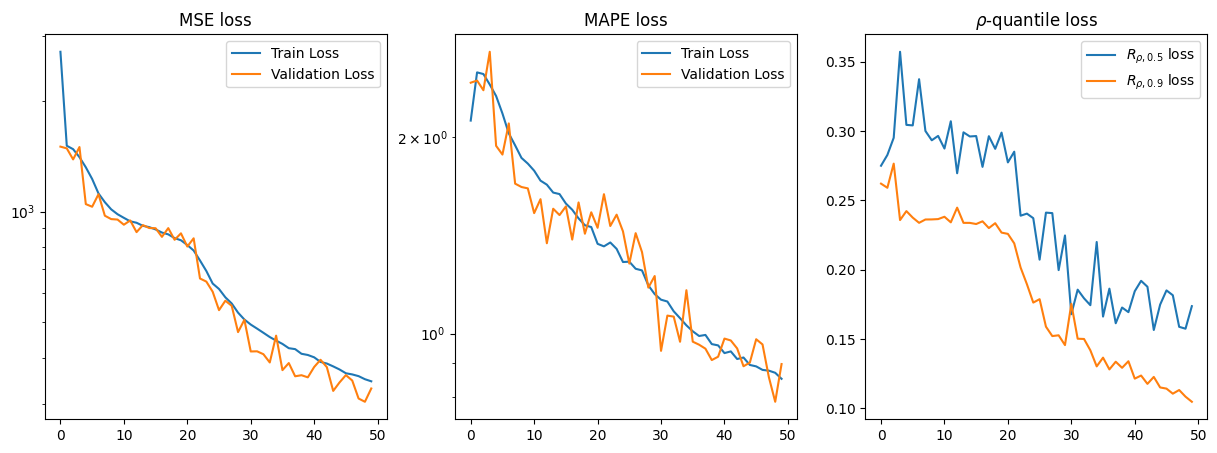

In [ ]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [ ]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(337.9434448242188,
 0.9549539384841919,
 [0.1756848692893982, 0.10639981180429459])

### N-step prediction

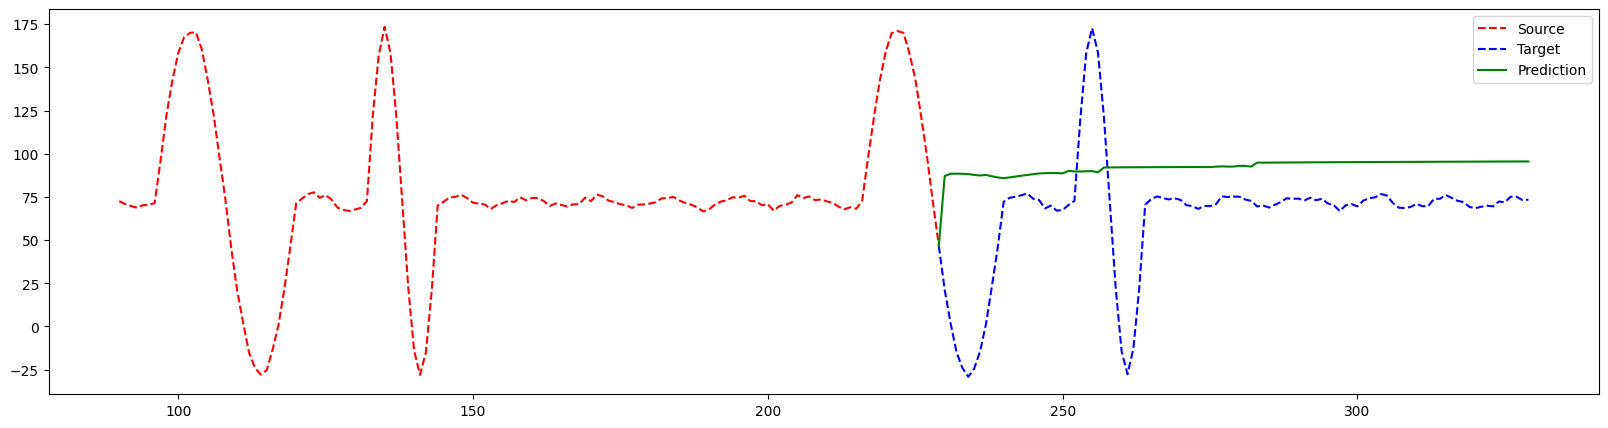

In [ ]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

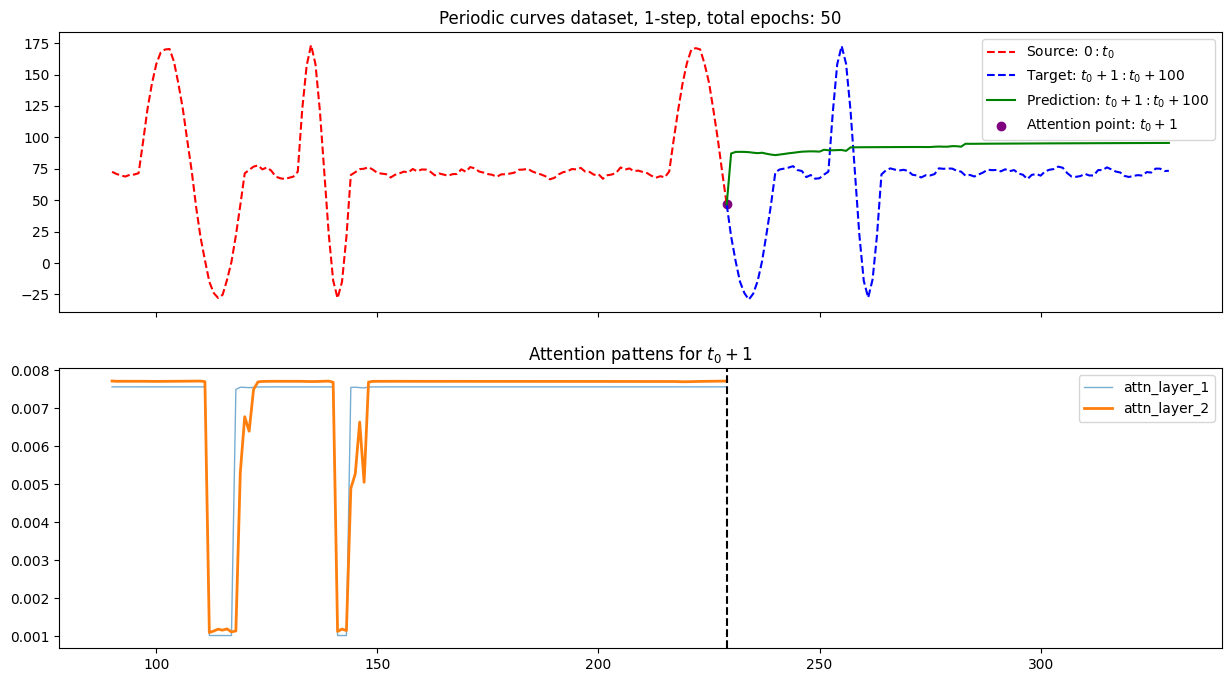

In [ ]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

In [ ]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 13: One-step and N-step prediction using *one head* and the *infinity norm* distance function.

In [ ]:
n_heads = 1                               # Number of heads used in multi headed simplex attention
distance_metric = infinity_norm                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [ ]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2663.2660	val_loss=1500.5442	train_mape_loss=2.6795	val_mape_loss=3.6920	R_p=['0.2761', '0.2604']
epoch=1	train_loss=1507.3006	val_loss=1447.7305	train_mape_loss=3.3150	val_mape_loss=3.6944	R_p=['0.2839', '0.2562']
epoch=2	train_loss=1448.1370	val_loss=1199.7665	train_mape_loss=3.2861	val_mape_loss=3.6533	R_p=['0.3235', '0.2308']
epoch=3	train_loss=1297.3303	val_loss=947.3216	train_mape_loss=2.9888	val_mape_loss=2.6320	R_p=['0.2870', '0.2316']
epoch=4	train_loss=1127.7603	val_loss=876.2465	train_mape_loss=2.6491	val_mape_loss=2.5955	R_p=['0.2853', '0.2349']
epoch=5	train_loss=1027.6757	val_loss=899.5300	train_mape_loss=2.4253	val_mape_loss=2.4188	R_p=['0.3022', '0.2359']
epoch=6	train_loss=951.7864	val_loss=912.4815	train_mape_loss=2.2787	val_mape_loss=2.4926	R_p=['0.3103', '0.2385']
epoch=7	train_loss=905.1691	val_loss=857.2501	train_mape_loss=2.1667	val_mape_loss=2.5582	R_p=['0.2806', '0.2418']
epoch=8	train_loss=885.1344	val_loss=840.8625	train_mape_loss=2.1594	va

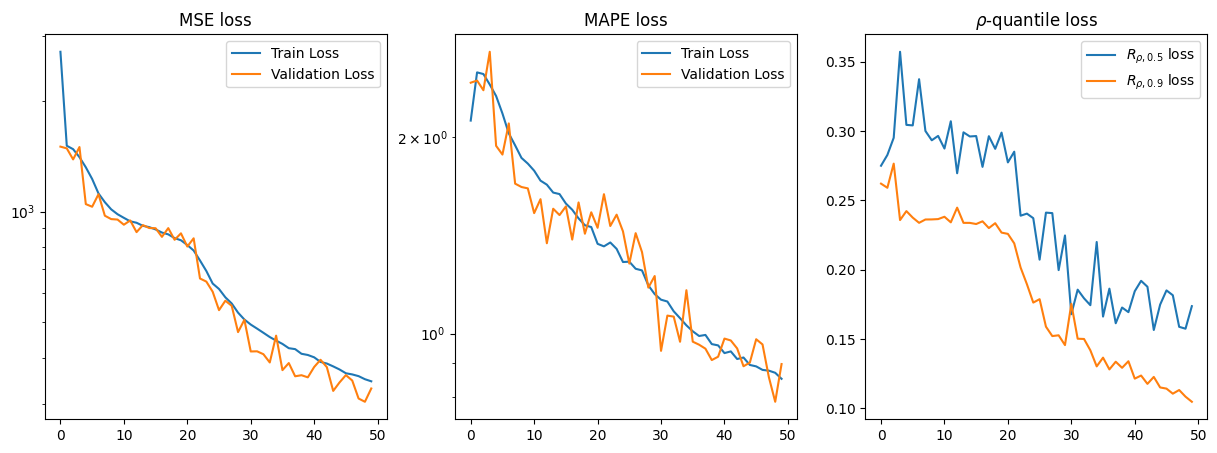

In [ ]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [ ]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(337.9434448242188,
 0.9549539384841919,
 [0.1756848692893982, 0.10639981180429459])

### N-step prediction

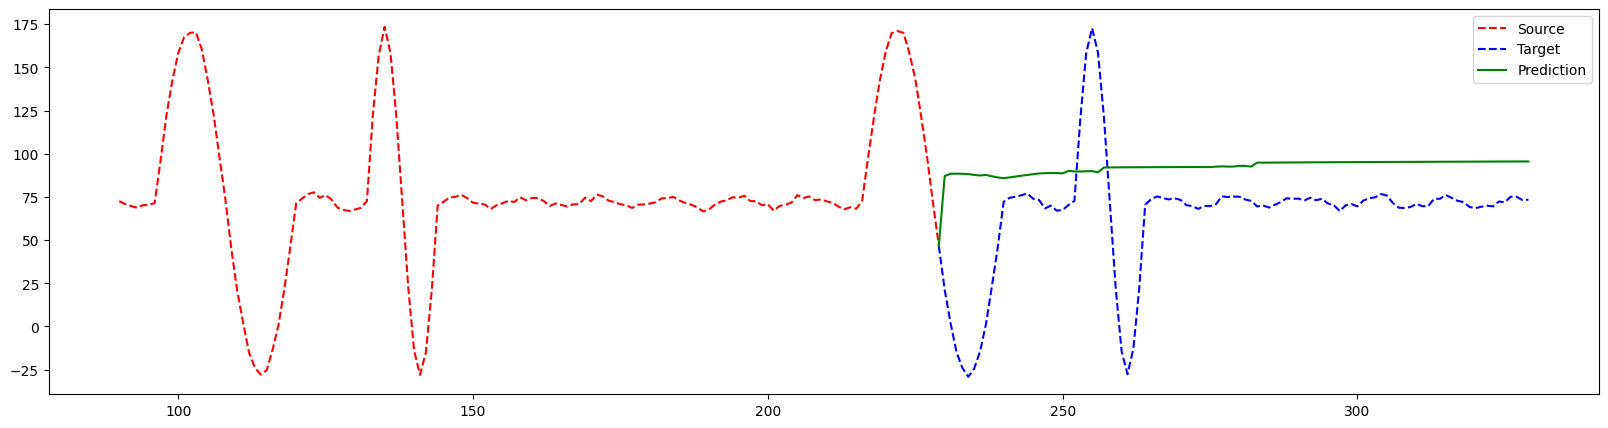

In [ ]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

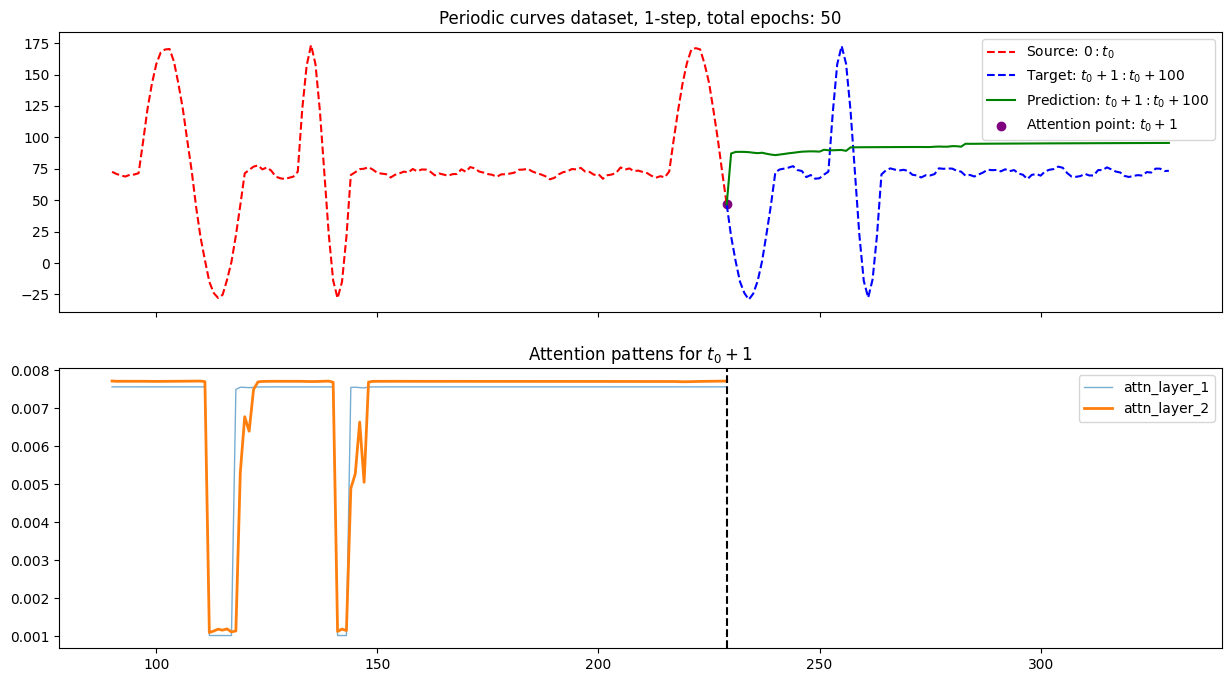

In [ ]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

In [ ]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 14: One-step and N-step prediction using *two heads* and the *infinity norm* distance function.

In [ ]:
n_heads = 2                               # Number of heads used in multi headed simplex attention
distance_metric = infinity_norm                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [ ]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2663.2660	val_loss=1500.5442	train_mape_loss=2.6795	val_mape_loss=3.6920	R_p=['0.2761', '0.2604']
epoch=1	train_loss=1507.3006	val_loss=1447.7305	train_mape_loss=3.3150	val_mape_loss=3.6944	R_p=['0.2839', '0.2562']
epoch=2	train_loss=1448.1370	val_loss=1199.7665	train_mape_loss=3.2861	val_mape_loss=3.6533	R_p=['0.3235', '0.2308']
epoch=3	train_loss=1297.3303	val_loss=947.3216	train_mape_loss=2.9888	val_mape_loss=2.6320	R_p=['0.2870', '0.2316']
epoch=4	train_loss=1127.7603	val_loss=876.2465	train_mape_loss=2.6491	val_mape_loss=2.5955	R_p=['0.2853', '0.2349']
epoch=5	train_loss=1027.6757	val_loss=899.5300	train_mape_loss=2.4253	val_mape_loss=2.4188	R_p=['0.3022', '0.2359']
epoch=6	train_loss=951.7864	val_loss=912.4815	train_mape_loss=2.2787	val_mape_loss=2.4926	R_p=['0.3103', '0.2385']
epoch=7	train_loss=905.1691	val_loss=857.2501	train_mape_loss=2.1667	val_mape_loss=2.5582	R_p=['0.2806', '0.2418']
epoch=8	train_loss=885.1344	val_loss=840.8625	train_mape_loss=2.1594	va

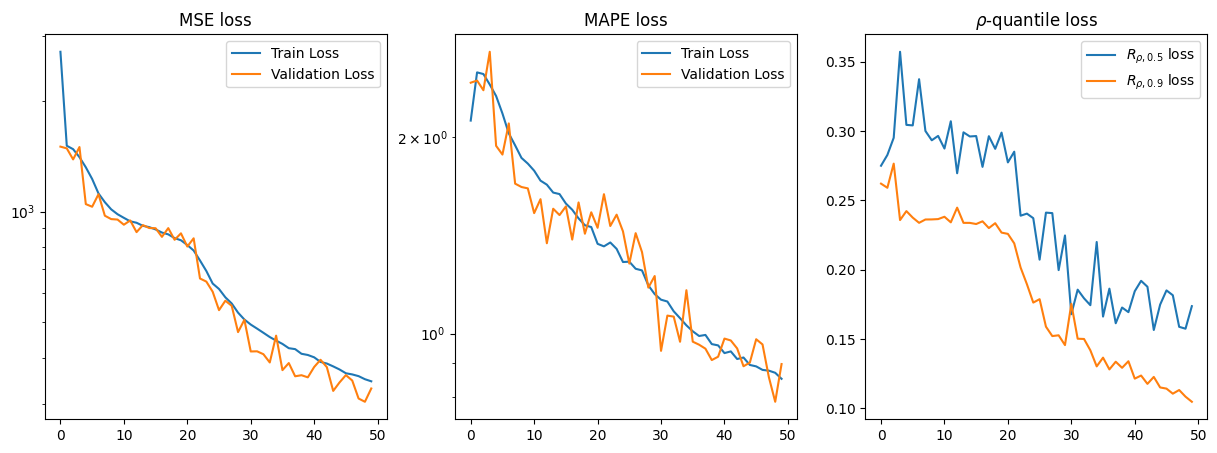

In [ ]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [ ]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(337.9434448242188,
 0.9549539384841919,
 [0.1756848692893982, 0.10639981180429459])

### N-step prediction

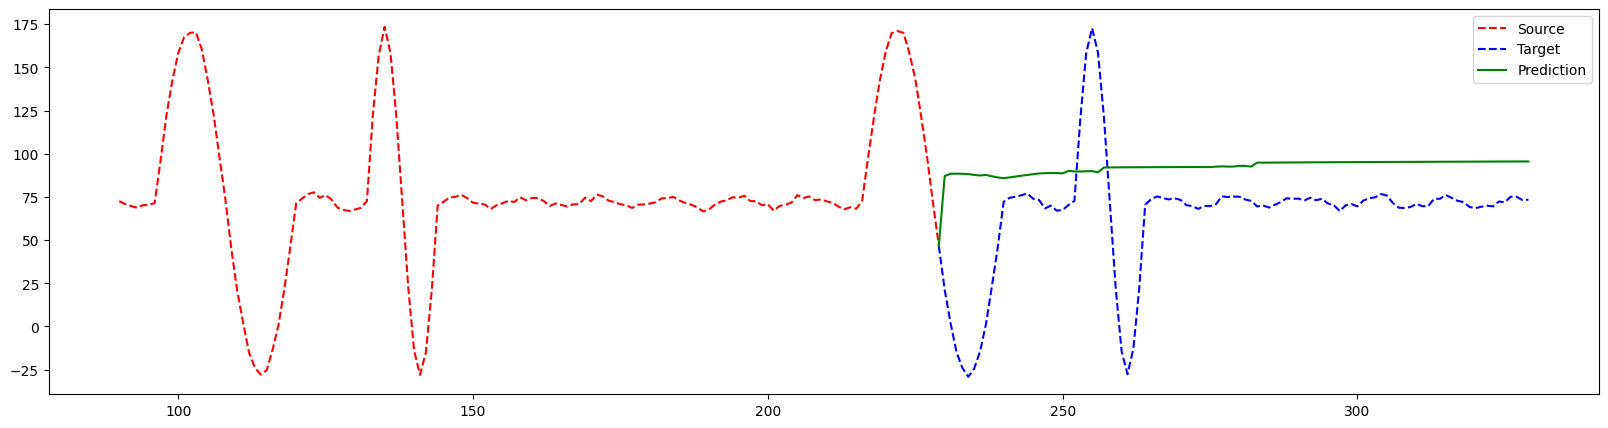

In [ ]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

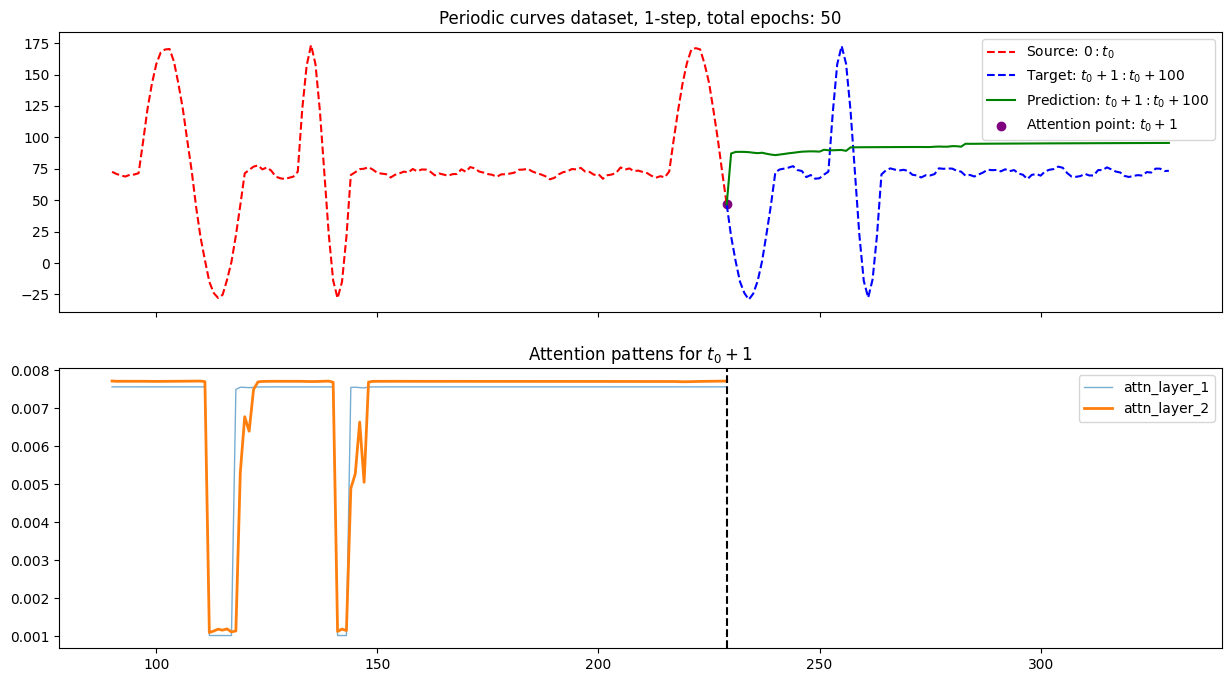

In [ ]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

In [ ]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 15: One-step and N-step prediction using *three heads* and the *infinity norm* distance function.

In [ ]:
n_heads = 3                               # Number of heads used in multi headed simplex attention
distance_metric = infinity_norm                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [ ]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2663.2660	val_loss=1500.5442	train_mape_loss=2.6795	val_mape_loss=3.6920	R_p=['0.2761', '0.2604']
epoch=1	train_loss=1507.3006	val_loss=1447.7305	train_mape_loss=3.3150	val_mape_loss=3.6944	R_p=['0.2839', '0.2562']
epoch=2	train_loss=1448.1370	val_loss=1199.7665	train_mape_loss=3.2861	val_mape_loss=3.6533	R_p=['0.3235', '0.2308']
epoch=3	train_loss=1297.3303	val_loss=947.3216	train_mape_loss=2.9888	val_mape_loss=2.6320	R_p=['0.2870', '0.2316']
epoch=4	train_loss=1127.7603	val_loss=876.2465	train_mape_loss=2.6491	val_mape_loss=2.5955	R_p=['0.2853', '0.2349']
epoch=5	train_loss=1027.6757	val_loss=899.5300	train_mape_loss=2.4253	val_mape_loss=2.4188	R_p=['0.3022', '0.2359']
epoch=6	train_loss=951.7864	val_loss=912.4815	train_mape_loss=2.2787	val_mape_loss=2.4926	R_p=['0.3103', '0.2385']
epoch=7	train_loss=905.1691	val_loss=857.2501	train_mape_loss=2.1667	val_mape_loss=2.5582	R_p=['0.2806', '0.2418']
epoch=8	train_loss=885.1344	val_loss=840.8625	train_mape_loss=2.1594	va

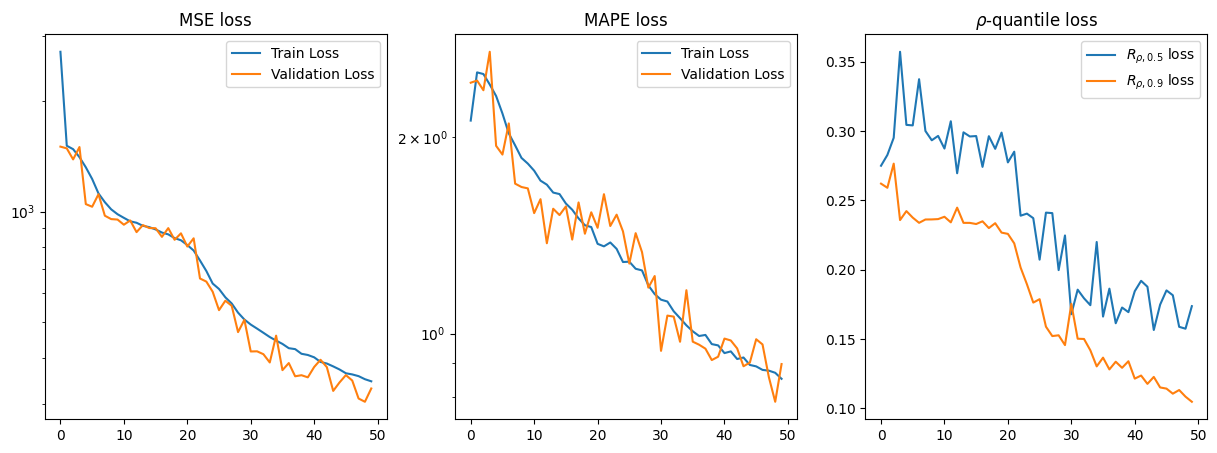

In [ ]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [ ]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(337.9434448242188,
 0.9549539384841919,
 [0.1756848692893982, 0.10639981180429459])

### N-step prediction

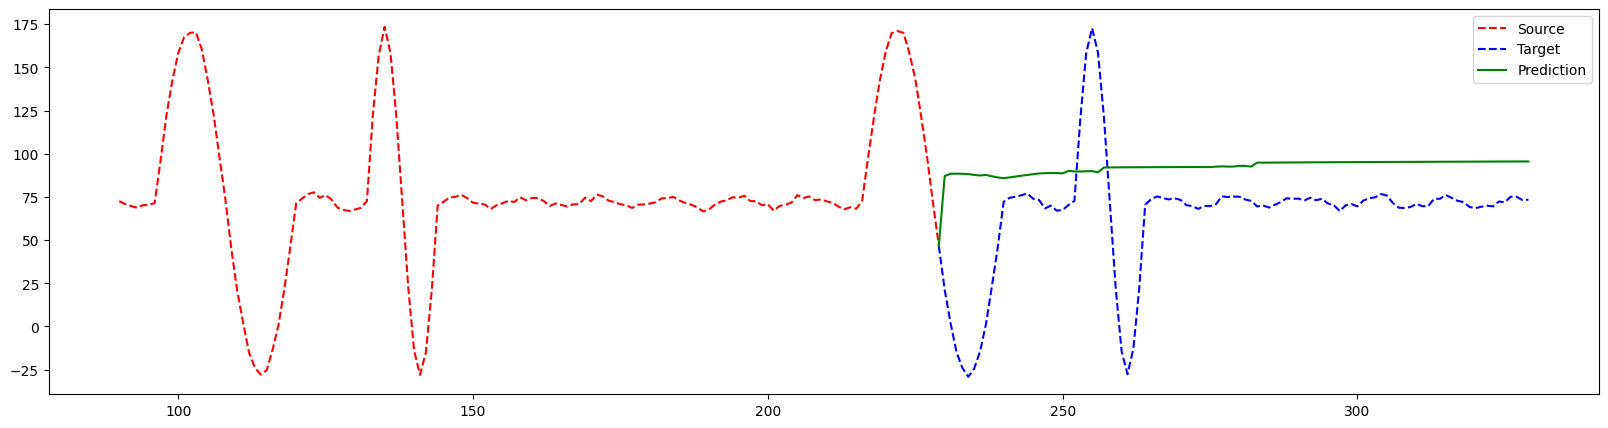

In [ ]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

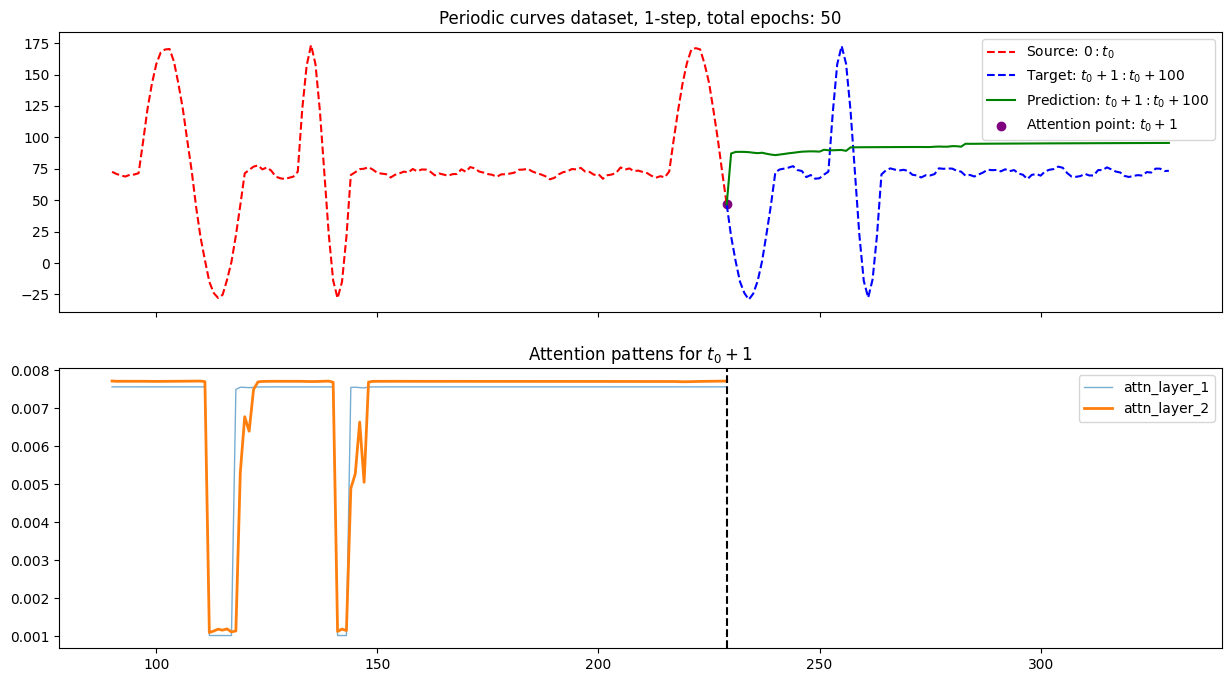

In [ ]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

In [ ]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

## Experiment 16: One-step and N-step prediction using *four heads* and the *infinity norm* distance function.

In [ ]:
n_heads = 1                               # Number of heads used in multi headed simplex attention
distance_metric = infinity_norm                  # Distance metric for multi headed simplex attention

model = PointSimplexDecoderOnlyTransformer(
    d_in=n_timeseries + 1,
    d_out=n_timeseries,       
    emb_size=emb_size,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=norm_first,
    distance_metric=distance_metric,
    conv_out_dim=conv_out_dim,
    kernel_size=kernel_size,
    n_heads=n_heads
).to(device)



train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [ ]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2663.2660	val_loss=1500.5442	train_mape_loss=2.6795	val_mape_loss=3.6920	R_p=['0.2761', '0.2604']
epoch=1	train_loss=1507.3006	val_loss=1447.7305	train_mape_loss=3.3150	val_mape_loss=3.6944	R_p=['0.2839', '0.2562']
epoch=2	train_loss=1448.1370	val_loss=1199.7665	train_mape_loss=3.2861	val_mape_loss=3.6533	R_p=['0.3235', '0.2308']
epoch=3	train_loss=1297.3303	val_loss=947.3216	train_mape_loss=2.9888	val_mape_loss=2.6320	R_p=['0.2870', '0.2316']
epoch=4	train_loss=1127.7603	val_loss=876.2465	train_mape_loss=2.6491	val_mape_loss=2.5955	R_p=['0.2853', '0.2349']
epoch=5	train_loss=1027.6757	val_loss=899.5300	train_mape_loss=2.4253	val_mape_loss=2.4188	R_p=['0.3022', '0.2359']
epoch=6	train_loss=951.7864	val_loss=912.4815	train_mape_loss=2.2787	val_mape_loss=2.4926	R_p=['0.3103', '0.2385']
epoch=7	train_loss=905.1691	val_loss=857.2501	train_mape_loss=2.1667	val_mape_loss=2.5582	R_p=['0.2806', '0.2418']
epoch=8	train_loss=885.1344	val_loss=840.8625	train_mape_loss=2.1594	va

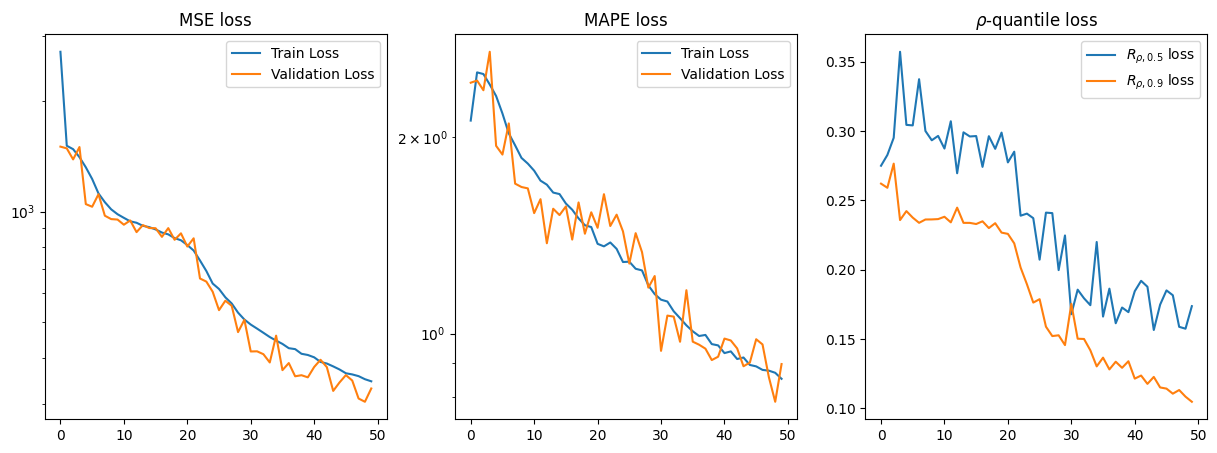

In [ ]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [ ]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(337.9434448242188,
 0.9549539384841919,
 [0.1756848692893982, 0.10639981180429459])

### N-step prediction

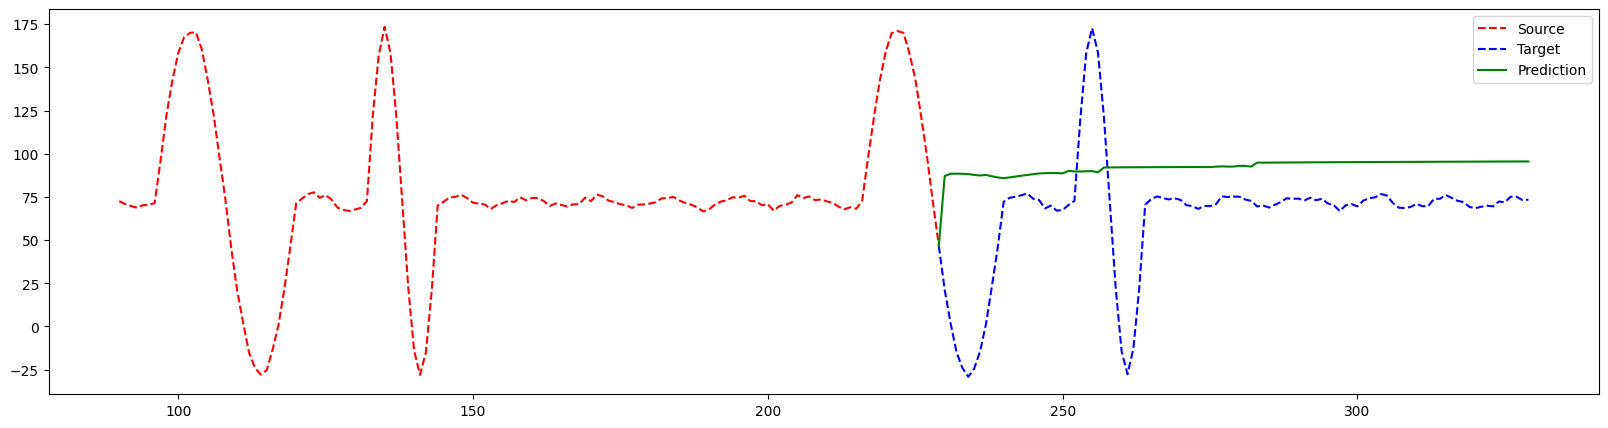

In [ ]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

### N-step prediciton and attention inspection

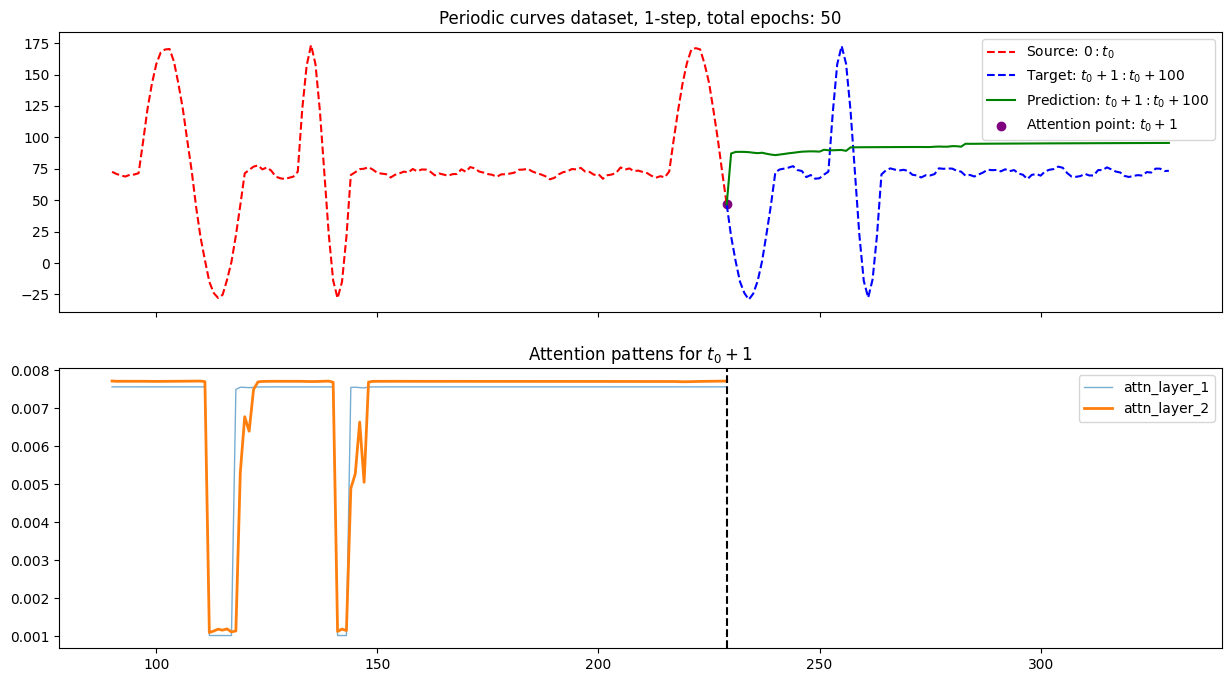

In [ ]:
inspect_step = 0
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

### One-step prediction

In [ ]:
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Source')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()